# WGCNA
weighted gene co-expression network analysis

# Phase 1 

following [Hovrath Lab Tutorial](https://www.dropbox.com/scl/fo/4vqfiysan6rlurfo2pbnk/h?dl=0&e=1&preview=Consensus-NetworkConstruction-man.pdf&rlkey=thqg8wlpdn4spu3ihjuc1kmlu) and [Phase 2 analysis](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/wgcna/wgcna_p2.ipynb)

## 0. load libraries

In [54]:
library(tidyverse)
library(DESeq2)
library(WGCNA)
library(janitor) # for row_to_names()
library(zoo)
library(ComplexHeatmap)
library(circlize)
library(reshape)
library(fastDummies) # create 0/1 factor columns
library(ape) # for read.gff
library(cowplot) # for plot_grid()
library(grid)

In [3]:
# important setting, cannot omit
options(stringsAsFactors = FALSE)

In [4]:
# allow multi-threading within WGCNA
enableWGCNAThreads()

Allowing parallel execution with up to 23 working processes.


## 1. structure WGCNA input

**Expected input**:
- Rows = samples
- Columns = genes (or probes/features)
- Values = numeric expression values

### A. format vst normalized counts matrix

In [5]:
# counts matrix
dataExpr <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/deseq_res_files/p1_vst.csv')

# set gene name as rowname
rownames(dataExpr) <- dataExpr$X

 
dataExpr <- dataExpr %>% 
select(-X) %>% # remove gene name as column
t() # transpose so samples = rows, genes = columns

head(dataExpr)
dim(dataExpr) # 23 samples x 38838 genes

,LOC111116054,LOC111126949,LOC111110729,LOC111112434,LOC111120752,LOC111128944,LOC111128953,LOC111105691,LOC111105685,LOC111105702,⋯,CYTB,COX2,ATP6,ND2,ND4,ND5,ND6,ND3,ND1,ND4L
B1_Nu_O03,5.745395,9.335715,8.042121,6.063003,9.203492,5.551009,5.551009,6.245676,5.551009,5.551009,⋯,19.11895,17.52187,17.30281,16.81575,18.68293,17.51576,15.53671,14.89731,17.39816,13.25330
B2_Nu_O12,6.362797,9.200133,7.986954,5.841331,8.926122,5.551009,5.551009,6.387114,5.551009,5.551009,⋯,19.73267,18.57488,17.79049,17.74730,17.92351,18.52736,16.49195,15.21946,17.75839,13.64041
B4_Nu_O32,6.239272,8.846718,8.013536,6.155955,8.690000,5.551009,5.551009,5.884044,5.551009,5.551009,⋯,19.00586,18.16016,17.90675,17.36563,17.48853,17.50631,16.22397,15.42412,17.86347,13.75912
B5_Nu_O36,6.284222,10.739705,8.013902,6.507433,8.294488,5.551009,5.551009,6.813333,5.551009,5.551009,⋯,18.80516,17.50273,17.21672,16.88583,17.56162,17.28275,15.74864,14.67081,16.74045,12.43115
B6_Nu_O47,5.765808,9.501493,8.115955,6.448616,8.755819,5.551009,5.551009,5.922369,5.551009,5.551009,⋯,19.33796,18.02881,17.32843,17.20749,17.42513,17.45075,15.97823,14.83971,17.00269,12.77437
C1_Nu_W01,6.328434,9.096392,7.730820,6.198007,9.697479,5.551009,5.828779,5.890945,5.551009,5.551009,⋯,19.23914,18.11948,17.90066,17.21709,17.62904,17.69223,16.40520,14.81986,17.69863,13.49222


[1]    23 38838

### B. identify and remove genes with missing data 
genes with too many NAs or zero-counts

In [6]:
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
gsg$allOK

dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
dim(dataExpr) # 94 samples x 35396 genes

 Flagging genes and samples with too many missing values...
  ..step 1
  ..Excluding 3857 genes from the calculation due to too many missing samples or zero variance.
  ..step 2


[1] FALSE

[1]    23 34981

### C. Sample size and gene filtering

removing low-variance genes first:

In [7]:
dataExpr <- dataExpr[, apply(dataExpr, 2, var) > quantile(apply(dataExpr, 2, var), 0.25)]
dim(dataExpr) # 23 samples x 26235 genes

[1]    23 26235

### D. Sample outlier detection

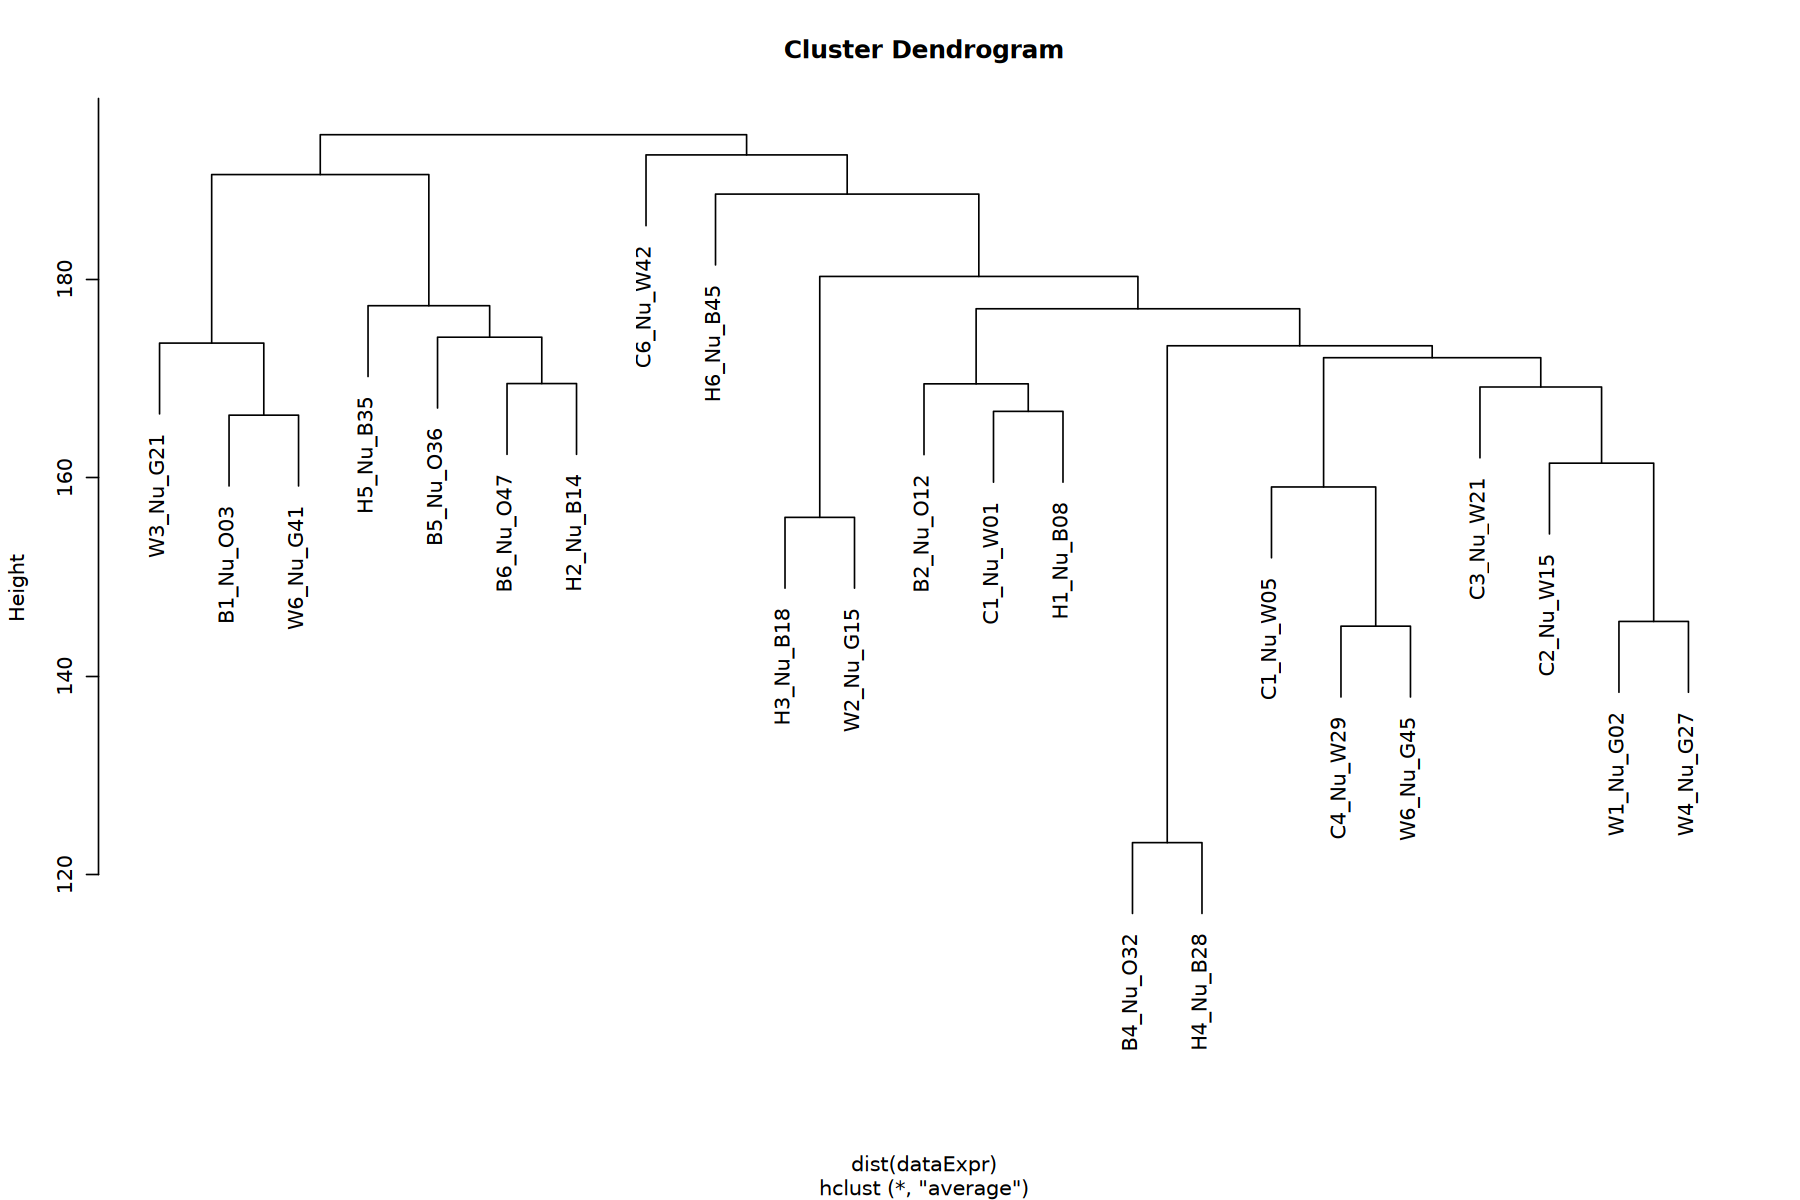

In [8]:
options(repr.plot.width = 15, repr.plot.height = 10)

sampleTree <- hclust(dist(dataExpr), method = "average")
plot(sampleTree)

only obvious outlier - B4_H1_O07 - becuase it clusters above the rest of the tree and is separated from the main cluster - going to remove it from analysis

doesn't appear to be any outliers to remove

### meta data
could add phenotypic data to this ...

In [9]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv') %>%
filter(grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

# removing same samples as dataExpr
meta <- meta[rownames(meta) %in% rownames(dataExpr), ]

head(meta)
dim(meta) # 92 samples

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_Nu_O03,both,warm,hypoxic,1,NA,NA,NA,NA
B2_Nu_O12,both,warm,hypoxic,2,NA,NA,NA,NA
B4_Nu_O32,both,warm,hypoxic,4,NA,NA,NA,NA
B5_Nu_O36,both,warm,hypoxic,5,NA,NA,NA,NA
B6_Nu_O47,both,warm,hypoxic,6,NA,NA,NA,NA
C1_Nu_W01,control,ambient,normoxic,1,NA,NA,NA,NA


[1] 23  8

In [10]:
# double checking the samples in rownames are the same
all(rownames(meta) == rownames(dataExpr))

[1] TRUE

## 2. simple WGCNA network construction and module identification
start with simple, can progress to consensus if deemed necessary

In [11]:
# final QC check
gsg <- goodSamplesGenes(dataExpr, verbose = 3)
if (!gsg$allOK) {
  dataExpr <- dataExpr[gsg$goodSamples, gsg$goodGenes]
}

gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### A. choose soft thresholding power (β)
analysis of network topology

In [12]:
powers <- c(1:20)
sft <- pickSoftThreshold(
  dataExpr,
  powerVector = powers,
  networkType = "signed",
  verbose = 5
)


pickSoftThreshold: will use block size 1705.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1705 of 26235
   ..working on genes 1706 through 3410 of 26235
   ..working on genes 3411 through 5115 of 26235
   ..working on genes 5116 through 6820 of 26235
   ..working on genes 6821 through 8525 of 26235
   ..working on genes 8526 through 10230 of 26235
   ..working on genes 10231 through 11935 of 26235
   ..working on genes 11936 through 13640 of 26235
   ..working on genes 13641 through 15345 of 26235
   ..working on genes 15346 through 17050 of 26235
   ..working on genes 17051 through 18755 of 26235
   ..working on genes 18756 through 20460 of 26235
   ..working on genes 20461 through 22165 of 26235
   ..working on genes 22166 through 23870 of 26235
   ..working on genes 23871 through 25575 of 26235
   ..working on genes 25576 through 26235 of 26235
   Power SFT.R.sq slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.1450 28.60 

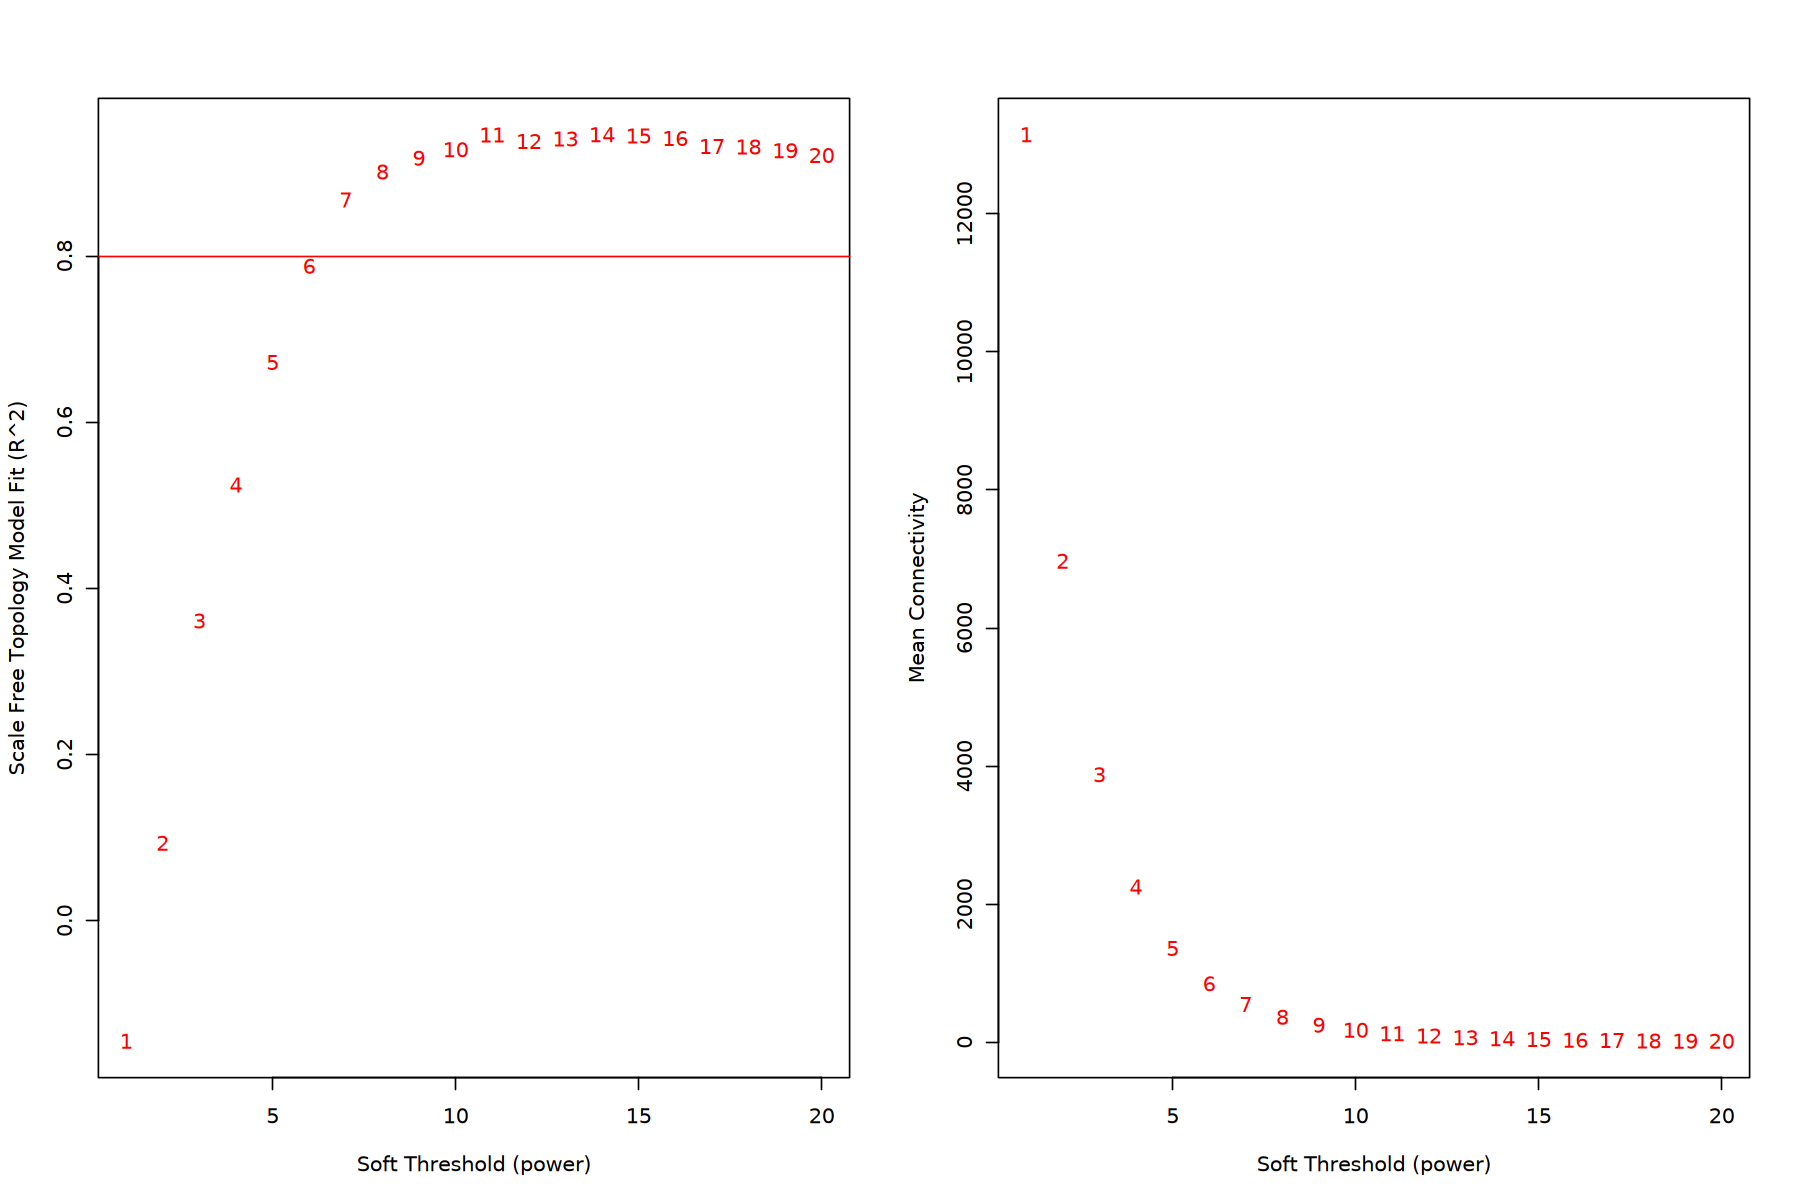

In [13]:
par(mfrow = c(1,2))
plot(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  xlab = "Soft Threshold (power)",
  ylab = "Scale Free Topology Model Fit (R^2)",
  type = "n"
)
text(
  sft$fitIndices[,1],
  -sign(sft$fitIndices[,3]) * sft$fitIndices[,2],
  labels = powers,
  col = "red"
)
abline(h = 0.8, col = "red")

plot(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  xlab = "Soft Threshold (power)",
  ylab = "Mean Connectivity",
  type = "n"
)
text(
  sft$fitIndices[,1],
  sft$fitIndices[,5],
  labels = powers,
  col = "red"
)


#### left plot - scale-free topology
the red line is where R^2 is 0.8 - you want the lowest power that reaches this - 6 is just below 0.8 and anything after 10 plateaus

#### right plot - mean connectivity
connectivity should not collapse to 0 - by power 8-10, the connectivity approaches 0

based on this, I think power of 7 should be appropriate

### B. co-expression similarity and adjacency

creating adjacency matrix

In [14]:
softPower <- 7

calculate co-expression adjacency using soft threshold power of 5

doing signed like the phase 2 vs. phase 2 analysis

In [15]:
# signed
adjacency_sign <- adjacency(dataExpr, power = softPower, type = 'signed') 
head(adjacency_sign)

,LOC111126949,LOC111120752,LOC111105691,LOC111133554,LOC111113860,LOC111109550,LOC111109753,LOC111109452,LOC111102393,LOC111119377,⋯,LOC111117482,COX3,CYTB,COX2,ND2,ND4,ND6,ND3,ND1,ND4L
LOC111126949,1.000000e+00,5.162636e-05,0.1872795549,0.016808270,3.205933e-02,0.004954696,0.0007814261,4.069538e-02,0.0094634987,0.0005957250,⋯,0.038590054,1.783890e-04,0.0019919883,0.0017664575,1.686669e-03,0.013079305,0.002996032,0.0012306049,1.033148e-04,0.0002706654
LOC111120752,5.162636e-05,1.000000e+00,0.0008596468,0.009310854,5.355783e-05,0.006659189,0.0152802476,9.112351e-07,0.0001026222,0.0073070336,⋯,0.003717499,1.208734e-01,0.0160960411,0.0087742944,3.250731e-03,0.014481100,0.005319170,0.0043947078,9.554674e-02,0.1071565557
LOC111105691,1.872796e-01,8.596468e-04,1.0000000000,0.046791873,3.726379e-02,0.004726359,0.0005944933,5.191265e-03,0.0005859588,0.0011555228,⋯,0.026864357,9.879182e-05,0.0001274675,0.0009541529,7.912375e-05,0.001475418,0.001249259,0.0005460995,3.428723e-05,0.0008837971
LOC111133554,1.680827e-02,9.310854e-03,0.0467918733,1.000000000,4.075280e-02,0.003929400,0.0010115670,2.365255e-03,0.0017643462,0.0004043957,⋯,0.011418584,7.895950e-04,0.0004352059,0.0004203165,3.029752e-04,0.022519266,0.003282341,0.0018837390,8.015468e-04,0.0033317790
LOC111113860,3.205933e-02,5.355783e-05,0.0372637904,0.040752798,1.000000e+00,0.009446666,0.0012421766,5.606668e-02,0.0270595000,0.0032284821,⋯,0.046866131,4.046764e-03,0.0025304009,0.0191029500,1.595400e-02,0.018536064,0.037678532,0.0275085604,1.038905e-03,0.0030500524
LOC111109550,4.954696e-03,6.659189e-03,0.0047263586,0.003929400,9.446666e-03,1.000000000,0.1458547164,4.172802e-02,0.0156807326,0.0034532884,⋯,0.005311493,6.205742e-02,0.0559296444,0.0996706878,1.498441e-02,0.011784608,0.037076753,0.0130724298,1.220273e-02,0.0374698042


In [16]:
 write.csv(data.frame(gene = rownames(adjacency_sign)), '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/wgcna/p1.wgcna_UniversalGeneList.csv', row.names = FALSE)

### C. Topological Overlap Matrix (TOM)
transform adjacency into TOM to minimize effects of noise and spurious associations - calculate corresponding dissimilarity

In [17]:
## SIGNED
# turn adjacency into topological overlap
TOM_sign <- TOMsimilarity(adjacency_sign)
head(TOM_sign)

# calculate dissimilarity
dissTOM_sign <- 1-TOM_sign
head(dissTOM_sign)

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


1.000000000,0.005714318,0.04475552,0.02308942,0.034795227,0.02374699,0.01356236,0.055886240,0.03249808,0.01064488,⋯,0.02998466,0.007689900,0.011949780,0.01492725,0.012848434,0.01821934,0.01814973,0.01753109,0.006518383,0.007465183
0.005714318,1.000000000,0.01637997,0.03569512,0.006678873,0.03523000,0.03154240,0.002604578,0.00632374,0.01859163,⋯,0.02828072,0.106264504,0.058308489,0.03295018,0.025420590,0.05910193,0.02716381,0.02163029,0.077960016,0.094523568
0.044755518,0.016379966,1.00000000,0.02593645,0.026978427,0.01413441,0.00928193,0.023307194,0.01272810,0.01473922,⋯,0.02069288,0.008894485,0.007531146,0.01111391,0.007774529,0.01103073,0.01344109,0.01108519,0.007169220,0.011092616
0.023089421,0.035695122,0.02593645,1.00000000,0.029076657,0.01610366,0.01030599,0.016218087,0.01359151,0.01158704,⋯,0.01710400,0.018368443,0.010424670,0.01223391,0.008930094,0.02532581,0.01661230,0.01364803,0.013337389,0.020308899
0.034795227,0.006678873,0.02697843,0.02907666,1.000000000,0.02608948,0.01458694,0.050227430,0.03536229,0.02015902,⋯,0.02901949,0.015502510,0.012479950,0.02671703,0.022407537,0.02222593,0.03292056,0.02890245,0.011939347,0.015703001
0.023746993,0.035230001,0.01413441,0.01610366,0.026089480,1.00000000,0.04033566,0.038334159,0.02954541,0.02251500,⋯,0.02244858,0.051071974,0.036017598,0.04746936,0.027959702,0.02977158,0.04109018,0.03572443,0.031441549,0.042266407


0.0000000,0.9942857,0.9552445,0.9769106,0.9652048,0.9762530,0.9864376,0.9441138,0.9675019,0.9893551,⋯,0.9700153,0.9923101,0.9880502,0.9850728,0.9871516,0.9817807,0.9818503,0.9824689,0.9934816,0.9925348
0.9942857,0.0000000,0.9836200,0.9643049,0.9933211,0.9647700,0.9684576,0.9973954,0.9936763,0.9814084,⋯,0.9717193,0.8937355,0.9416915,0.9670498,0.9745794,0.9408981,0.9728362,0.9783697,0.9220400,0.9054764
0.9552445,0.9836200,0.0000000,0.9740635,0.9730216,0.9858656,0.9907181,0.9766928,0.9872719,0.9852608,⋯,0.9793071,0.9911055,0.9924689,0.9888861,0.9922255,0.9889693,0.9865589,0.9889148,0.9928308,0.9889074
0.9769106,0.9643049,0.9740635,0.0000000,0.9709233,0.9838963,0.9896940,0.9837819,0.9864085,0.9884130,⋯,0.9828960,0.9816316,0.9895753,0.9877661,0.9910699,0.9746742,0.9833877,0.9863520,0.9866626,0.9796911
0.9652048,0.9933211,0.9730216,0.9709233,0.0000000,0.9739105,0.9854131,0.9497726,0.9646377,0.9798410,⋯,0.9709805,0.9844975,0.9875200,0.9732830,0.9775925,0.9777741,0.9670794,0.9710976,0.9880607,0.9842970
0.9762530,0.9647700,0.9858656,0.9838963,0.9739105,0.0000000,0.9596643,0.9616658,0.9704546,0.9774850,⋯,0.9775514,0.9489280,0.9639824,0.9525306,0.9720403,0.9702284,0.9589098,0.9642756,0.9685585,0.9577336


### D. Call the hierarchical clustering function - plot the tree
hierarchical clustering tree (dendrogram) of genes

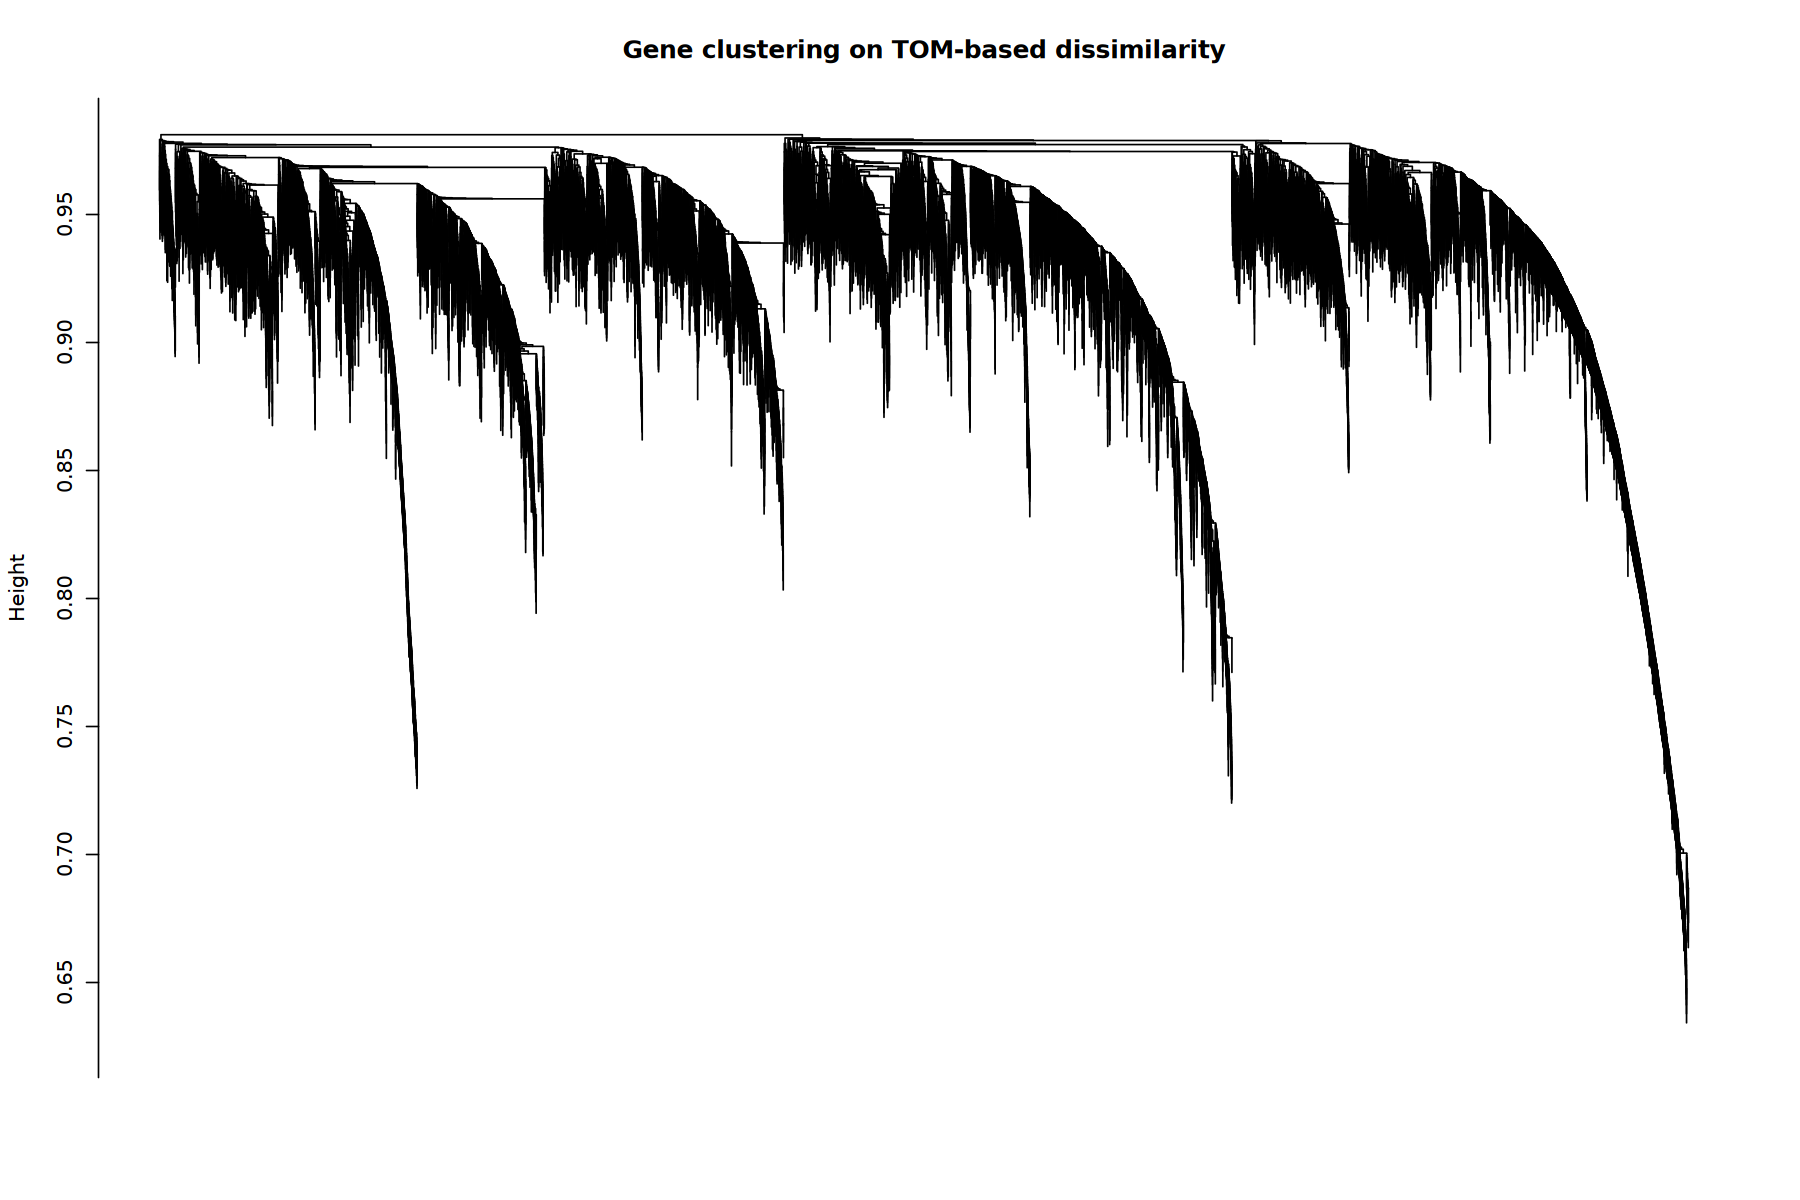

In [18]:
# call hierarchical clustering function
geneTree_sign = hclust(as.dist(dissTOM_sign), method = "average")

# plot the dendrogram
plot(geneTree_sign, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",labels = FALSE, hang = 0.04)

each leaf (short vertical line) corresponds to a gene - branches group together densely interconnected, highly co-expressed genes

module identification = cutting branches off the dendrogram

### E. module identification

set minimum module size - this is the smallest number of genes allowed to be put into a module 

then use Dynamic Tree Cut which is the default method for branch cutting and module detection

In [19]:
# would like large modules, so we set the minimum module size relatively high:
minModuleSize <- 100

## SIGNED
# Module identification using dynamic tree cut:
dynamicMods_sign <- cutreeDynamic(dendro = geneTree_sign, distM = dissTOM_sign, 
                             deepSplit = 2, pamRespectsDendro = FALSE,
                             minClusterSize = minModuleSize)
table(dynamicMods_sign) # number of genes per module

 ..cutHeight not given, setting it to 0.979  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods_sign
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
4035 3900 2234 2048 1856 1826 1581 1299 1170 1122  791  637  442  376  363  346 
  17   18   19   20   21   22   23   24   25   26   27 
 301  279  226  222  205  200  171  166  156  142  141 

27 modules generated

convert numeric network to colors and plots dendrogram:

dynamicColors_sign
        black          blue         brown          cyan     darkgreen 
         1581          3900          2234           376           200 
     darkgrey    darkorange       darkred darkturquoise         green 
          166           142           205           171          1856 
  greenyellow        grey60     lightcyan    lightgreen   lightyellow 
          791           301           346           279           226 
      magenta  midnightblue        orange          pink        purple 
         1170           363           156          1299          1122 
          red     royalblue        salmon           tan     turquoise 
         1826           222           442           637          4035 
        white        yellow 
          141          2048 

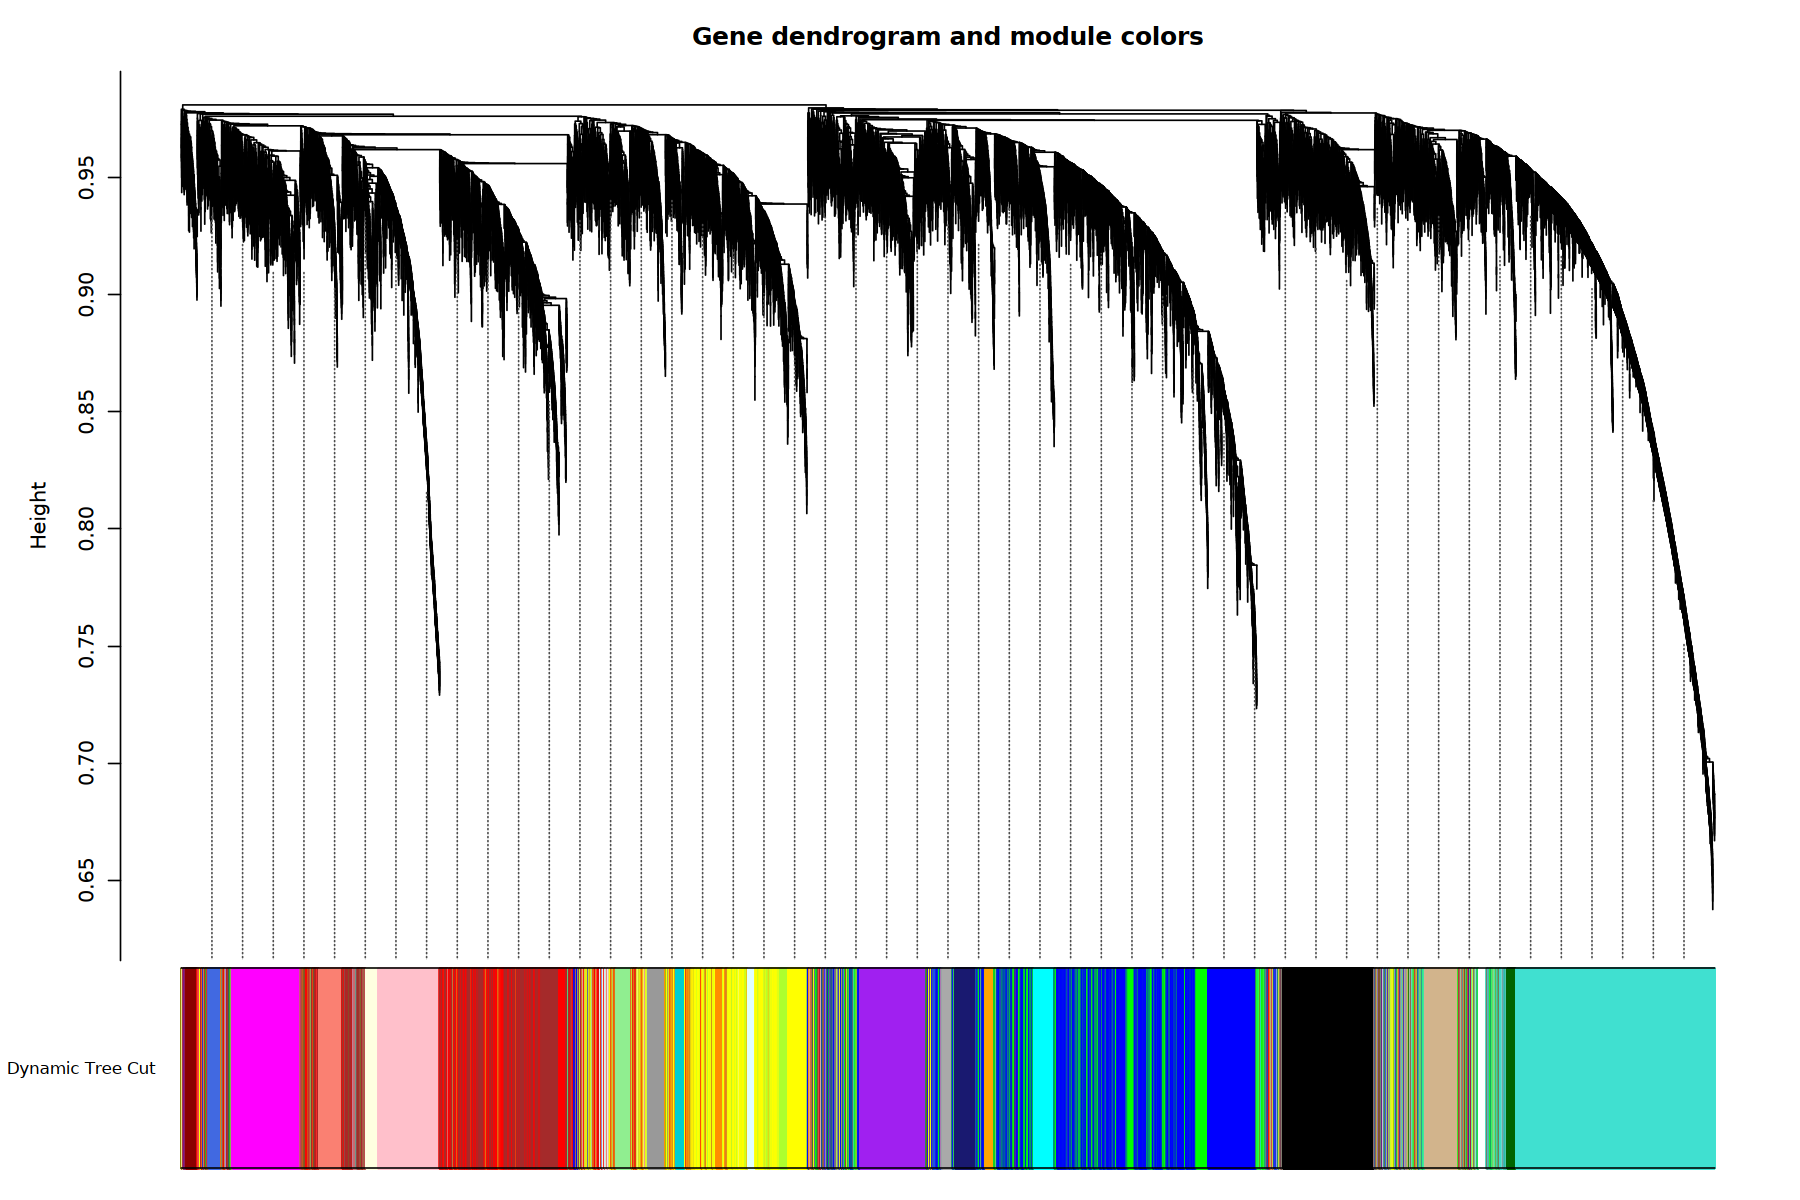

In [20]:
## SIGNED
# Convert numeric lables into colors
dynamicColors_sign <- labels2colors(dynamicMods_sign)
table(dynamicColors_sign)

# Plot the dendrogram and colors underneath
plotDendroAndColors(geneTree_sign, dynamicColors_sign, "Dynamic Tree Cut",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05,
                    main = "Gene dendrogram and module colors")


### F. merging modules whose GE profiles are similar

this is based on eigengenes, which is the first principal component of a given a gene expression matrix/module that acts as a representative summary profile for a gene module or cluster

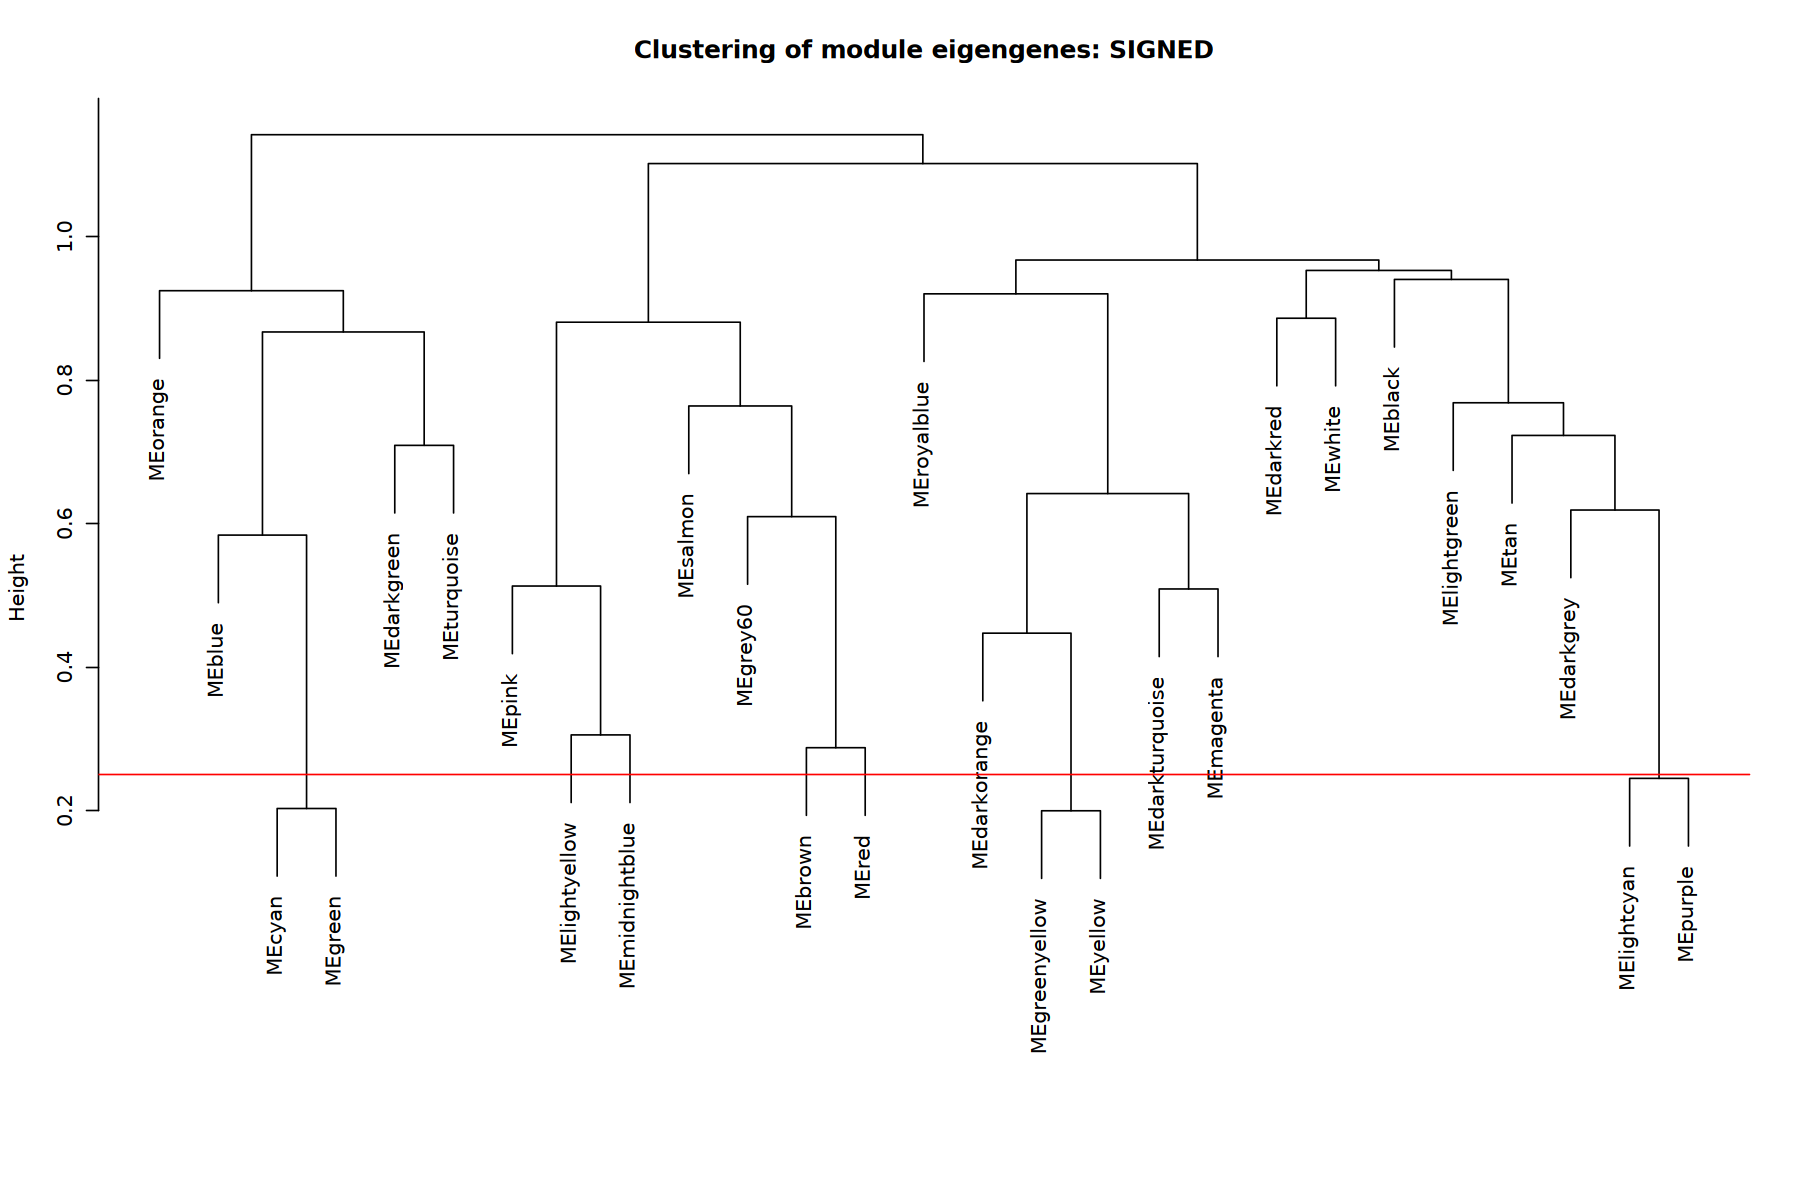

In [21]:
## SIGNED
# Calculate eigengenes
MEList_sign <- moduleEigengenes(dataExpr, colors = dynamicColors_sign)
MEs_sign <- MEList_sign$eigengenes

# Calculate dissimilarity of module eigengenes
MEDiss_sign <- 1-cor(MEs_sign)

# Cluster module eigengenes
METree_sign <- hclust(as.dist(MEDiss_sign), method = "average")

# Plot the result

# height cutoff of 0.25 - corresponds to a correlation of 0.75 to merge
MEDissThres <- 0.25

# Plot the cut line into the dendrogram
plot(METree_sign, main = "Clustering of module eigengenes: SIGNED", xlab = "", sub = "")
abline(h=MEDissThres, col = "red")

any branch with more than 75% correlation are related and will be merged - so blue and purple modules will be merged

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 27 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 24 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 24 module eigengenes in given set.


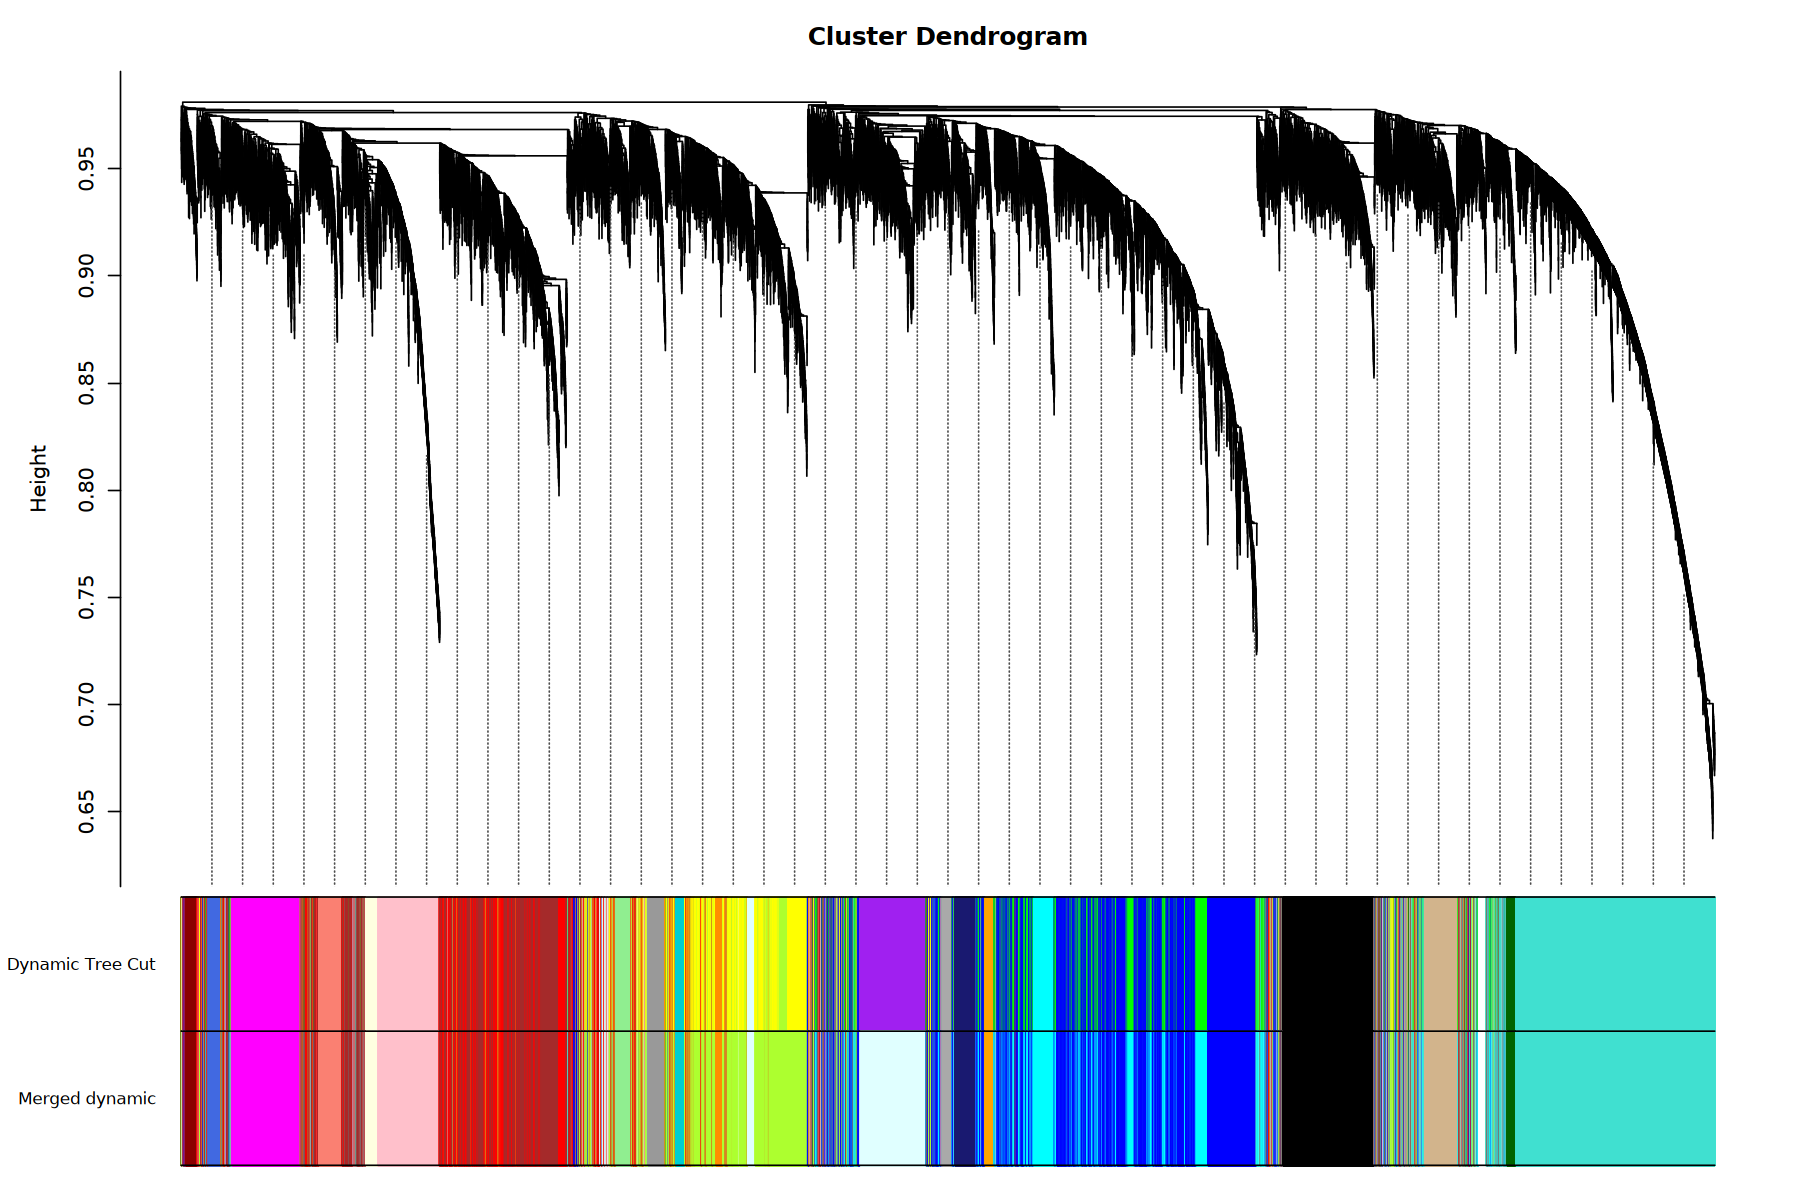

In [22]:
## SIGNED
# Call an automatic merging function
merge_sign <- mergeCloseModules(dataExpr, dynamicColors_sign, cutHeight = MEDissThres, verbose = 3)

# The merged module colors
mergedColors_sign <- merge_sign$colors

# Eigengenes of the new merged modules:
mergedMEs_sign <- merge_sign$newMEs

# plot merged module colors
plotDendroAndColors(geneTree_sign, cbind(dynamicColors_sign, mergedColors_sign), 
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [23]:
table(mergedColors_sign)

mergedColors_sign
        black          blue         brown          cyan     darkgreen 
         1581          3900          2234          2232           200 
     darkgrey    darkorange       darkred darkturquoise   greenyellow 
          166           142           205           171          2839 
       grey60     lightcyan    lightgreen   lightyellow       magenta 
          301          1468           279           226          1170 
 midnightblue        orange          pink           red     royalblue 
          363           156          1299          1826           222 
       salmon           tan     turquoise         white 
          442           637          4035           141 

23 modules ranging from 141 - 4035 genes

301 genes were unassigned to a module (grey60)

In [24]:
# Recalculate MEs (module eigengenes) with color labels

MEs0 <- moduleEigengenes(dataExpr, mergedColors_sign)$eigengenes # create module eigengenes

MEs <- orderMEs(MEs0) # order so more similar modules are closer together
head(MEs)

,MEroyalblue,MEdarkturquoise,MEmagenta,MEpink,MElightyellow,MEmidnightblue,MEsalmon,MEgrey60,MEbrown,MEred,⋯,MEdarkgreen,MEturquoise,MEblack,MEtan,MElightgreen,MElightcyan,MEdarkorange,MEgreenyellow,MEdarkred,MEwhite
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B1_Nu_O03,-0.09680250,-0.04312175,-0.15543345,-0.1507972,-0.13004246,-0.007761003,0.331391047,0.0002399047,-0.11149471,-0.09339968,⋯,-0.037837127,-0.27753985,-0.03354692,-0.09672766,-0.10639008,0.09455738,-0.05263704,-0.10423298,-0.098270253,-0.005017845
B2_Nu_O12,-0.08627217,-0.04975691,-0.18392626,-0.1376832,-0.03661193,-0.067412347,-0.073969002,-0.0520701670,-0.13004083,-0.22166954,⋯,0.971136251,0.25471134,-0.08565975,-0.17249177,-0.05877204,-0.03672860,-0.04774071,-0.09001361,0.002279854,-0.052784863
B4_Nu_O32,0.01010212,0.11218962,-0.03448318,-0.1250349,-0.02849276,-0.041047320,0.002610909,-0.0798428714,0.10102702,0.04413762,⋯,0.007868579,0.12839397,0.66020145,-0.05195118,-0.06270238,-0.04389120,-0.19673657,-0.04509032,-0.041945239,-0.078026777
B5_Nu_O36,-0.14241939,-0.01909647,-0.11190226,-0.1472628,-0.07026207,-0.138861512,-0.034372513,0.9649848155,0.22719122,0.44801960,⋯,-0.059568186,-0.28854691,-0.03549333,-0.07880733,-0.07290245,0.14290617,0.01412687,0.37315803,-0.095047047,-0.018554898
B6_Nu_O47,-0.01866037,0.92300564,0.33570504,-0.1289872,-0.12526846,-0.093211082,-0.092916511,-0.0354971729,-0.07011925,0.12822974,⋯,-0.051385081,-0.26380391,-0.02096985,-0.08729185,-0.03013241,0.11168616,0.26250596,0.38761455,-0.071747626,0.017491909
C1_Nu_W01,-0.10247095,-0.09483828,-0.13401531,-0.1487413,-0.16557263,0.001615946,-0.086578522,-0.0777336819,-0.27951807,-0.22174573,⋯,-0.032362080,0.08622511,-0.09892508,-0.13173958,-0.05603869,0.11322712,0.27445902,-0.04043069,-0.086420297,-0.099300681


In [25]:
# write.csv(MEs, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/wgcna/p1.wgcna_ModuleEigengenes.csv')

## 3. quantifying module-trait associations
identify modules that are significantly associated with treatment exposures or measured traits (like growth)

### A. read in and format metadata

both treatment metadata and growth data

In [26]:
# read in phase info
dataMeta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv')

# keep only samples seen in dataExpr
dataMeta <- dataMeta[dataMeta$Sample %in% rownames(dataExpr),] 

# check it out
dim(dataMeta)
head(dataMeta)

[1] 23  9

,Sample,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
2,B1_Nu_O03,both,warm,hypoxic,1,NA,NA,NA,NA
6,B2_Nu_O12,both,warm,hypoxic,2,NA,NA,NA,NA
19,B4_Nu_O32,both,warm,hypoxic,4,NA,NA,NA,NA
25,B5_Nu_O36,both,warm,hypoxic,5,NA,NA,NA,NA
30,B6_Nu_O47,both,warm,hypoxic,6,NA,NA,NA,NA
35,C1_Nu_W01,control,ambient,normoxic,1,NA,NA,NA,NA


In [27]:
# creating dummy variables

#### PHASE 1 ####
# phase 1 treatments
phase1.treatments <- dataMeta %>%
  select(Sample, Phase1_treatment) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = Phase1_treatment,
    values_from = value,
    values_fill = list(value = 0)
  )

head(phase1.treatments)

# phase 1 DO
phase1.DO <- dataMeta %>%
  select(Sample, Phase1_DO) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = Phase1_DO,
    values_from = value,
    values_fill = list(value = 0)
  )

# phase 1 temperature
phase1.temp <- dataMeta %>%
  select(Sample, Phase1_temp) %>%
  mutate(value = 1) %>%
  pivot_wider(
    id_cols = Sample,
    names_from = Phase1_temp,
    values_from = value,
    values_fill = list(value = 0)
  )


Sample,both,control,hypoxic,warm
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
B1_Nu_O03,1,0,0,0
B2_Nu_O12,1,0,0,0
B4_Nu_O32,1,0,0,0
B5_Nu_O36,1,0,0,0
B6_Nu_O47,1,0,0,0
C1_Nu_W01,0,1,0,0


In [28]:
nSamples <- nrow(dataExpr) # 23 samples
nGenes <- ncol(dataExpr) # 26235 genes

In [29]:
# module trait correlation

## PHASE 1 ##
# phase 1 treatment
moduleTraitCor_p1 = cor(MEs, phase1.treatments[-1], use = "p")
moduleTraitPvalue_p1 = corPvalueStudent(moduleTraitCor_p1, nSamples)

# phase 1 DO
moduleTraitCor_p1.DO = cor(MEs, phase1.DO[-1], use = "p")
moduleTraitPvalue_p1.DO = corPvalueStudent(moduleTraitCor_p1.DO, nSamples)

# phase 1 temp
moduleTraitCor_p1.temp = cor(MEs, phase1.temp[-1], use = "p")
moduleTraitPvalue_p1.temp = corPvalueStudent(moduleTraitCor_p1.temp, nSamples)


#### phase 1 treatments

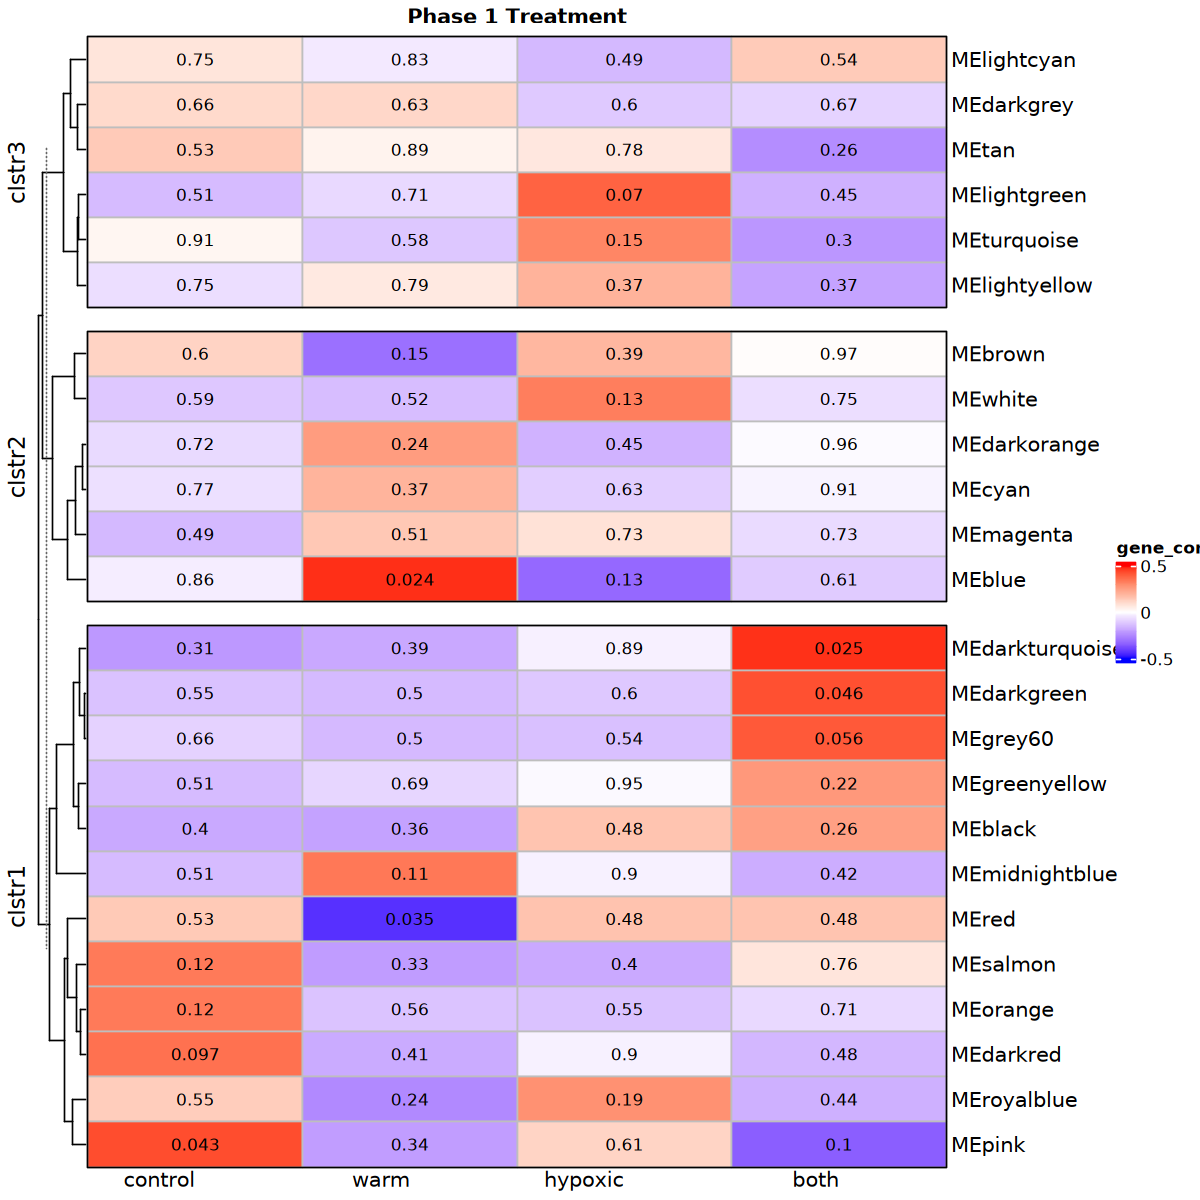

In [48]:
options(repr.plot.width = 10, repr.plot.height = 10)

# Define your desired order based on your actual column names
my_col_order = c("control", "warm", "hypoxic", "both") 

p1.treatment.text <-  as.matrix(signif(moduleTraitPvalue_p1, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(p1.treatment.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

p1_treatment.heatmap <- Heatmap(moduleTraitCor_p1, 
        column_order = my_col_order,
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 1 Treatment", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 0,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", p1.treatment.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

p1_treatment.heatmap

so the color denotes the correlation, the text within the heatmap denotes the p-value

**higher module eigengene-treatment correlation = higher expression of the module with the given trait/treatment**
- red = lower expression in the given treatment
- blue = higher expression in the given treatment


#### conclusions here:
based on the results below (only 1 significant module when focusing on one stressor type), it seems that for module one there's more of an interaction of stressors that are important - in other words, it's the combination of temperature and DO that makes a difference here 
- darkgreen and darkturquoise modules are significantly pos. correlated with both (so these genes have higher expression in both treatment compared to all other treatments)
- red module is significantly neg. correlated with warm
- pink module is significantly pos. correlated with control

#### phase 1 temp

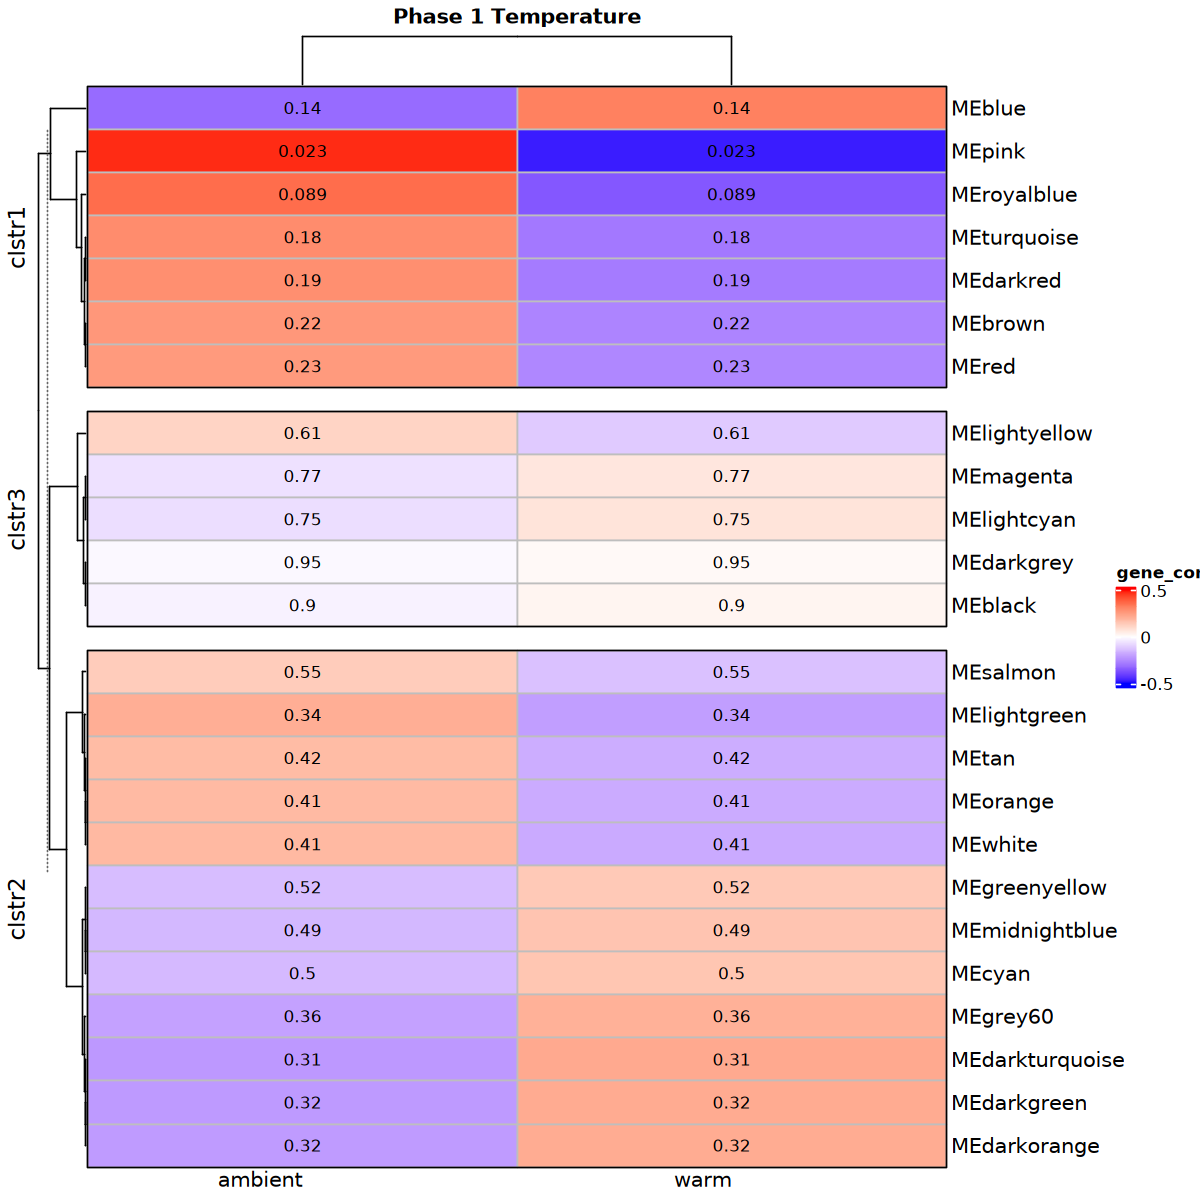

In [49]:
options(repr.plot.width = 10, repr.plot.height = 10)

p1.temp.text <-  as.matrix(signif(moduleTraitPvalue_p1.temp, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(p1.temp.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

p1_temp.heatmap <- Heatmap(moduleTraitCor_p1.temp, 
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 1 Temperature", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 0,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", p1.temp.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

p1_temp.heatmap

#### conclusions here:
- only one significantly correlated modules: pink 
- pink is sig. negatively correlated with warming (regardless of DO treatment)

#### phase 1 DO

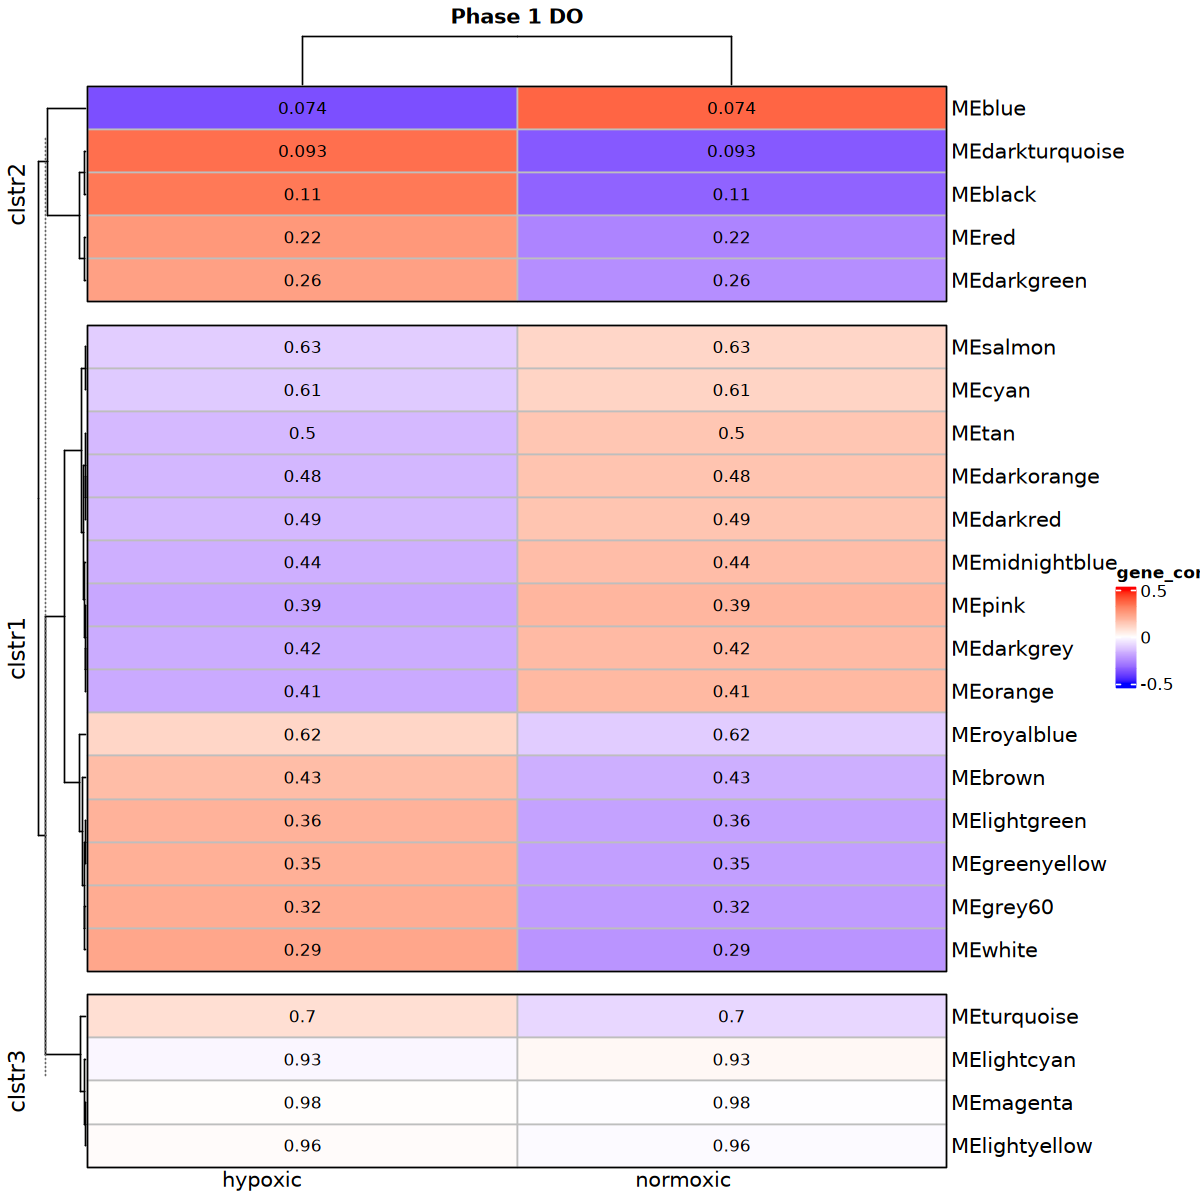

In [50]:
options(repr.plot.width = 10, repr.plot.height = 10)

p1.DO.text <-  as.matrix(signif(moduleTraitPvalue_p1.DO, 4))
# cluster modules based on p-value similarity
pa = cluster::pam(p1.DO.text, k = 3)
col_fun = colorRamp2(c(-0.5, 0, 0.5), c("blue", "white", "red"))

p1_DO.heatmap <- Heatmap(moduleTraitCor_p1.DO, 
        name = "gene_cor", 
        rect_gp = gpar(col = "grey", lwd = 1),
        column_title = "Phase 1 DO", 
        column_title_gp = gpar(fontsize = 12, fontface = "bold"),
        # row_title = "WGCNA modules",
        #row_km = 4, 
        column_names_rot = 0,
        column_km = 1,
        row_split = paste0("clstr", pa$clustering),
        row_gap = unit(5, "mm"),
        column_gap = unit(5, "mm"),
        # grid.text(matrix(textMatrix)),
        # border = TRUE,
        border = TRUE,
        col = col_fun,
        cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2g", p1.DO.text[i, j]), x, y,
          gp = gpar(fontsize = 10))
        })

p1_DO.heatmap

#### conclusions here:
- no significantly correlated modules

### combine heatmaps to one plot

In [51]:
# 1. Create a helper function to convert ComplexHeatmap to a grob
as_grob_hm <- function(hm) {
  grid.grabExpr(draw(hm))
}

# 2. Convert all your heatmaps
p1_temp_g <- as_grob_hm(p1_temp.heatmap)
p1_DO_g <- as_grob_hm(p1_DO.heatmap)
p1_treatment_g <- as_grob_hm(p1_treatment.heatmap)

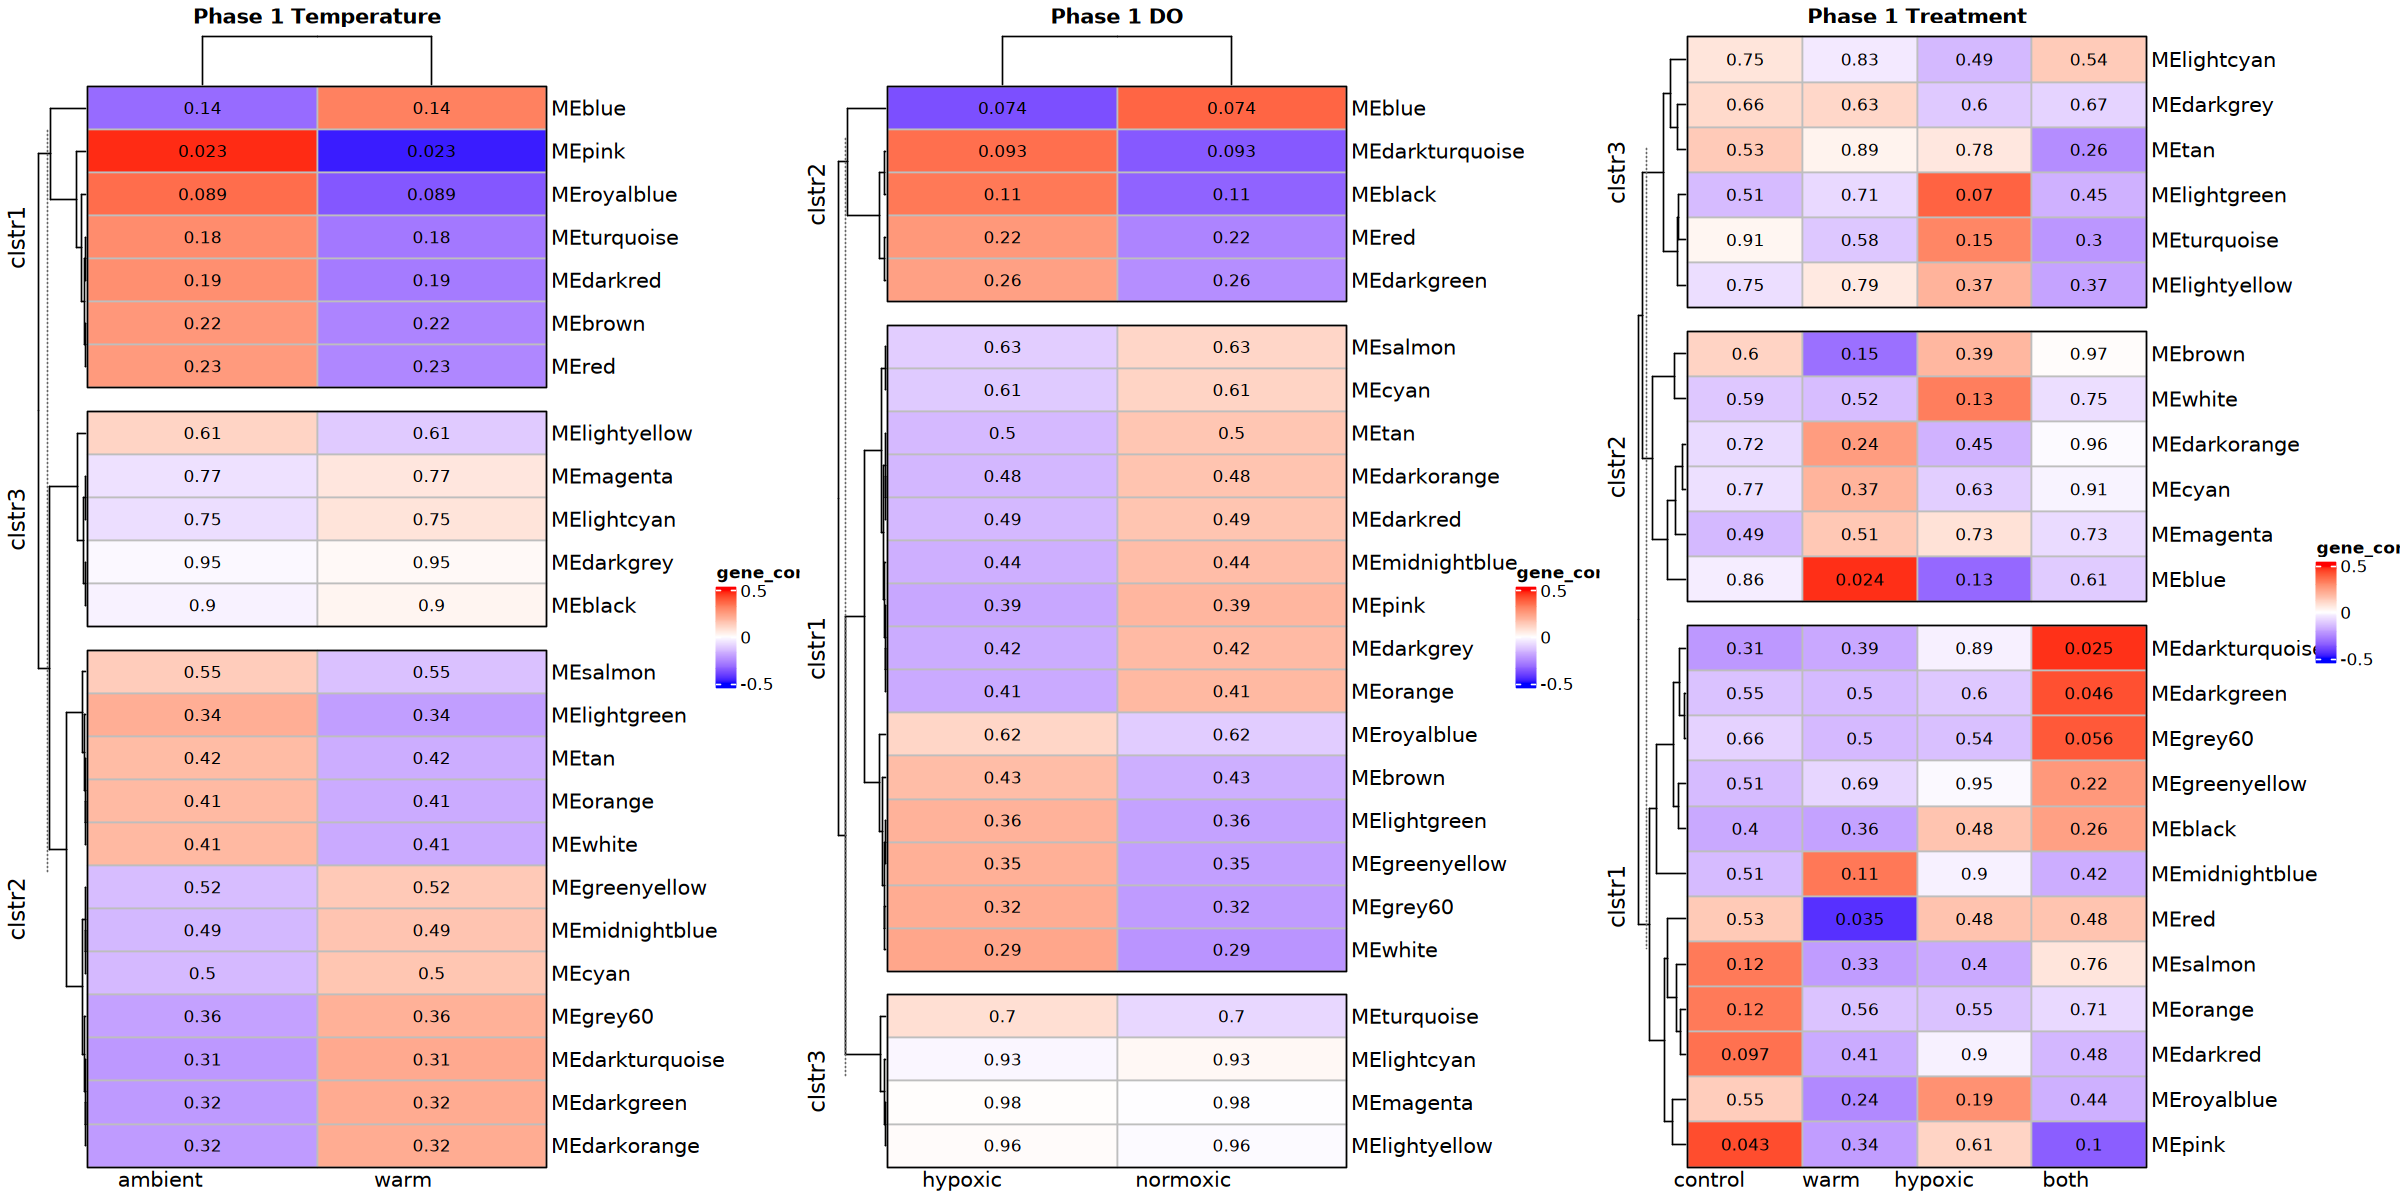

In [56]:
options(repr.plot.width = 20, repr.plot.height = 10)

# 3. Use plot_grid with the new grob objects
all_heatmaps <- plot_grid(p1_temp_g, p1_DO_g, p1_treatment_g,
          nrow = 1, ncol = 3)

all_heatmaps

some of the axes are not in the same order bc of clustering - I think I'm okay with that since it's informative for the treatments

In [129]:
ggsave(
  filename = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase2/wgcna/plots/module_heatmaps_p2.png', 
  plot = all_heatmaps, 
  width = 20,       # Half the width
  height = 15,     # Roughly half the height
  units = "in", 
  dpi = 300         # High resolution for clarity
)

## MEs boxplots by treatment group

inspo for this comes from [Gurr's code](https://github.com/SamGurr/Pgenerosa_OA_TagSeq/blob/main/TagSeq/Analysis/Scripts/Day21_WGCNA_all.R) - plotting every module's ME (module eigengene) for each treatment combination - this will allow me to take a closer look at the relationship between modules and phase 1 and 2 treatments


then create df to plot boxplots - want the metadata and module eigengene info in long format

In [33]:
# Create ME table
MEs_df <- as.data.frame(MEs)
MEs_df$Sample <- rownames(MEs_df)

# format metadata and merge with MEs
dataMeta2 <- dataMeta[,1:4]
dim(dataMeta2)

# merge MEs and metadata
MEsPlotting <- merge(dataMeta2, MEs_df, by = 'Sample')

# Melt to long format
MEsPlotting_melt <- reshape2::melt(
  MEsPlotting,
  id.vars = c("Sample",
              "Phase1_treatment",
              "Phase1_temp",
              "Phase1_DO"
             ),
  variable.name = "Module",
  value.name = "Eigengene"
)

MEsPlotting_melt <- MEsPlotting_melt %>%
filter(!grepl('code', Module)) # remove treatment code rows

head(MEsPlotting_melt)

[1] 23  4

,Sample,Phase1_treatment,Phase1_temp,Phase1_DO,Module,Eigengene
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,B1_Nu_O03,both,warm,hypoxic,MEroyalblue,-0.09680250
2,B2_Nu_O12,both,warm,hypoxic,MEroyalblue,-0.08627217
3,B4_Nu_O32,both,warm,hypoxic,MEroyalblue,0.01010212
4,B5_Nu_O36,both,warm,hypoxic,MEroyalblue,-0.14241939
5,B6_Nu_O47,both,warm,hypoxic,MEroyalblue,-0.01866037
6,C1_Nu_W01,control,ambient,normoxic,MEroyalblue,-0.10247095


In [34]:
# save metadata in case I skip code above
# write.csv(MEsPlotting_melt[,1:13], '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/wgcna/p2.wgcna_metadata.csv')

make boxplot!

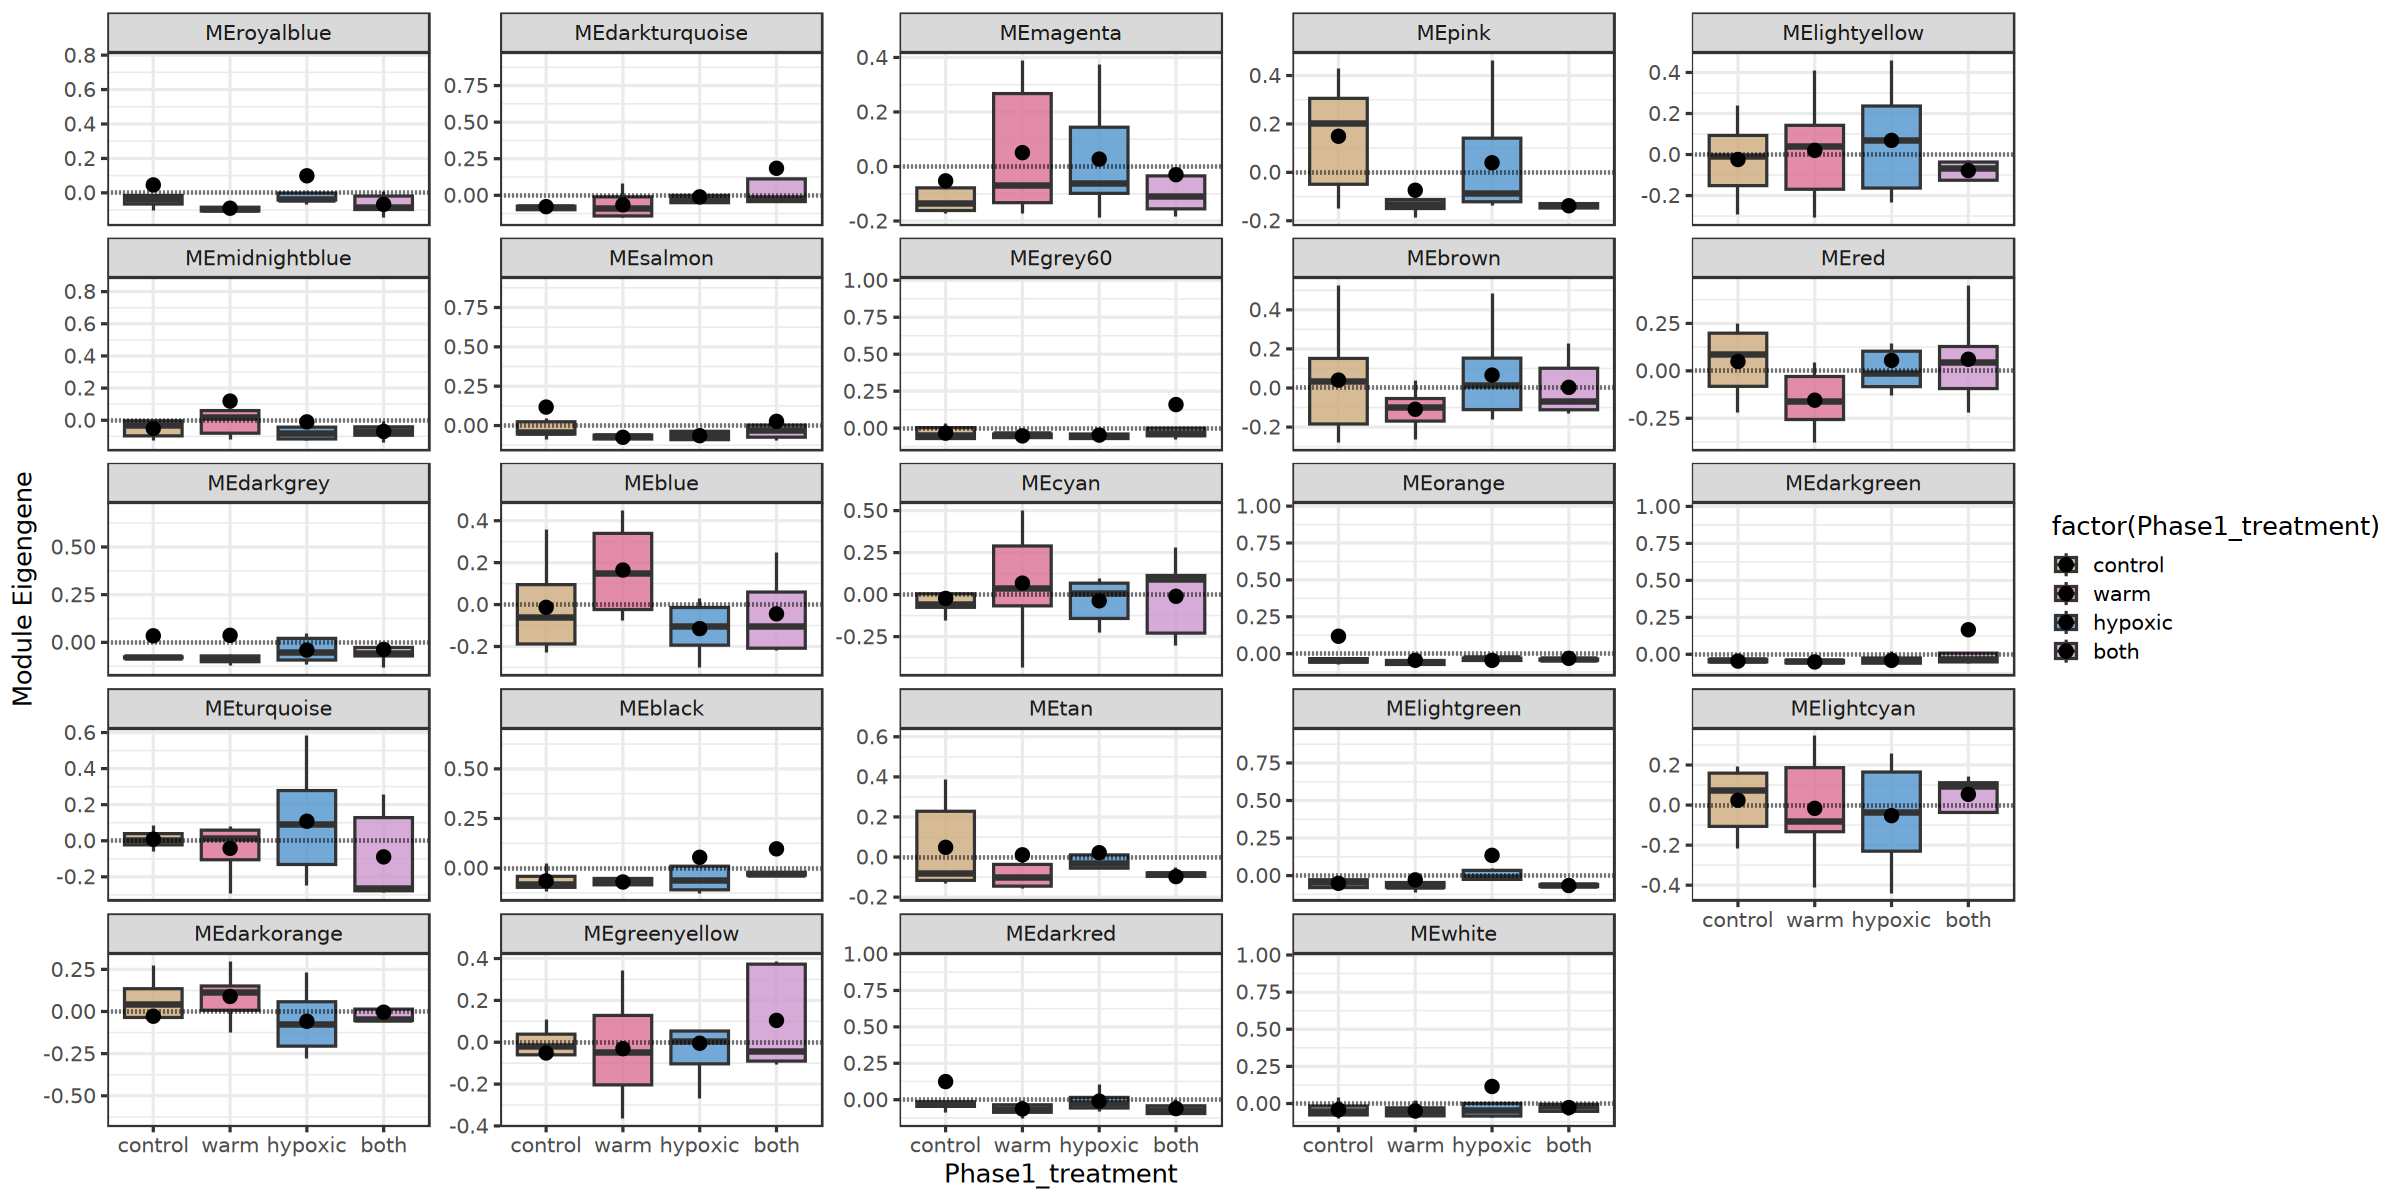

In [46]:
options(repr.plot.width = 20, repr.plot.hieght = 15)

MEsPlotting_melt$Phase1_treatment <- factor(MEsPlotting_melt$Phase1_treatment, levels = c('control', 'warm', 'hypoxic', 'both'))

MEs_boxplot <- ggplot(MEsPlotting_melt,
       aes(x = Phase1_treatment,
           y = Eigengene,
           fill = factor(Phase1_treatment))) +
  
  geom_boxplot(position = position_dodge(0.8),
               outlier.shape = NA,
               alpha = 0.8) +

scale_fill_manual(values = c("hypoxic" = "steelblue3", 
                             "warm" = "palevioletred", 
                             "control" = "burlywood3", 
                             "both" = "plum3")) +
  
  stat_summary(fun = mean,
               geom = "point",
               color = "black",
               position = position_dodge(0.8),
               size = 3) +
  
  geom_hline(yintercept = 0,
             linetype = "dotted",
             linewidth = 1) +
  
  ylab("Module Eigengene") +
  theme_bw(base_size=15) +
  facet_wrap(~ Module, scales = "free_y")
MEs_boxplot

red and pink modules look the most interesting

the other modules that were significantly correlated with a treatment (darkgreen and darkturquoise) don't look that interesting in this light

In [47]:
ggsave(
  filename = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/wgcna/plots/MEs_boxplots_p1.png', 
  plot = MEs_boxplot, 
  width = 20,       # Half the width
  height = 15,     # Roughly half the height
  units = "in", 
  dpi = 300         # High resolution for clarity
)

## Gene significance (GS) and module membership (MM)
both are critical metrics for identifying hub genes within modules that are associated with specific treatment/traits
- GS = correlates gene expression with treatment/trait
- MM = how well a gene belongs to a module

basically select a module of interest and validate with GS and MM - combine GS and MM to find genes that are highly connected *and* strongly associated with the treatment/trait

In [36]:
modNames <- substring(names(MEs), 3)
modNames

[1] "royalblue"     "darkturquoise" "magenta"       "pink"         
 [5] "lightyellow"   "midnightblue"  "salmon"        "grey60"       
 [9] "brown"         "red"           "darkgrey"      "blue"         
[13] "cyan"          "orange"        "darkgreen"     "turquoise"    
[17] "black"         "tan"           "lightgreen"    "lightcyan"    
[21] "darkorange"    "greenyellow"   "darkred"       "white"

#### module membership
MM is the same across all treatments

In [37]:
geneModuleMembership = as.data.frame(cor(dataExpr, MEs, use = "p"))
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))

names(geneModuleMembership) = paste("MM", modNames, sep="")
names(MMPvalue) = paste("p.MM", modNames, sep="")

In [38]:
head(geneModuleMembership)

,MMroyalblue,MMdarkturquoise,MMmagenta,MMpink,MMlightyellow,MMmidnightblue,MMsalmon,MMgrey60,MMbrown,MMred,⋯,MMdarkgreen,MMturquoise,MMblack,MMtan,MMlightgreen,MMlightcyan,MMdarkorange,MMgreenyellow,MMdarkred,MMwhite
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC111126949,-0.03402151,0.0003317737,0.06696037,0.38566565,0.29907123,0.2968736,0.1977552,0.5306680,0.48741443,0.54072882,⋯,-0.12597831,-0.27492505,-0.161902637,-0.08428088,0.04511246,-0.21334843,-0.11453713,0.269240003,-0.16727985,-0.11078781
LOC111120752,-0.19278761,-0.1873443204,-0.36046326,-0.37910957,-0.25364734,0.2140756,-0.1847299,-0.2779149,-0.69432599,-0.84974503,⋯,0.04906286,-0.02544802,-0.043118466,-0.18162809,-0.16214783,0.19109045,0.32145903,-0.389983725,0.11539586,0.11885674
LOC111105691,-0.34324019,-0.1383652859,-0.09819263,0.10311466,-0.22557746,-0.1150310,0.1524588,0.2925515,-0.05810989,0.21339544,⋯,0.06462228,-0.19504983,-0.133583282,-0.03875285,0.28842669,0.26263047,0.23418604,0.331217456,-0.18535700,0.25635984
LOC111133554,-0.17474716,-0.1577192498,-0.35524586,0.08991956,-0.26461376,-0.1277845,0.3248708,0.1526770,-0.08636487,0.03235039,⋯,0.04863021,-0.24967651,-0.002684143,-0.12640416,0.38938076,0.24395658,-0.01388683,-0.002007344,-0.10708656,0.04119249
LOC111113860,0.07288303,0.1672213722,-0.06508904,0.44403206,-0.01949769,-0.1425721,0.5097612,-0.1771264,0.32876060,0.37266628,⋯,0.09107692,-0.04874637,0.274163507,0.07995849,0.18287094,0.04573958,-0.32074699,-0.010478352,0.06424137,-0.01397640
LOC111109550,0.06296583,-0.3094634854,0.08286456,0.53479037,0.31977792,0.2245067,0.2636864,-0.2943970,0.28204509,-0.13759538,⋯,-0.04404756,-0.04589081,-0.271637332,-0.08613176,0.11524964,-0.36238133,-0.42182763,-0.482156932,-0.04635626,-0.37630996


#### gene significance
calculated for each treatment combination

In [39]:
# List all trait sets you want to process
trait_sets <- list(
  phase1_temp = phase1.temp[-1],
  phase1_DO = phase1.DO[-1],
    phase1_treatment = phase1.treatments[-1]
)

# Initialize lists to store results
geneTraitSignificance_all <- list()
GSPvalue_all <- list()

# Loop over each trait set
for(set_name in names(trait_sets)){
  traits_df <- trait_sets[[set_name]]
  
  # Get trait names
  trait_names <- colnames(traits_df)
  
  # Initialize lists for this set
  gs_list <- list()
  gs_p_list <- list()
  
  for(trt in trait_names){
    trt_df <- as.data.frame(traits_df[[trt]])
    names(trt_df) <- trt
    
    # Compute gene-trait significance and p-values
    gs <- as.data.frame(cor(dataExpr, trt_df, use = "p"))
    gs_p <- as.data.frame(corPvalueStudent(as.matrix(gs), nSamples))
    
    # Rename columns
    names(gs) <- paste0("GS.", trt)
    names(gs_p) <- paste0("p.GS.", trt)
    
    # Store in lists
    gs_list[[trt]] <- gs
    gs_p_list[[trt]] <- gs_p
  }
  
  # Combine into data frames for this set
  geneTraitSignificance_all[[set_name]] <- do.call(cbind, gs_list)
  GSPvalue_all[[set_name]] <- do.call(cbind, gs_p_list)
}

# Optional: combine all sets into one big data frame each
geneTraitSignificance_df <- do.call(cbind, geneTraitSignificance_all)
GSPvalue_df <- do.call(cbind, GSPvalue_all)

In [40]:
head(geneTraitSignificance_df) 

,phase1_temp.GS.warm,phase1_temp.GS.ambient,phase1_DO.GS.hypoxic,phase1_DO.GS.normoxic,phase1_treatment.GS.both,phase1_treatment.GS.control,phase1_treatment.GS.hypoxic,phase1_treatment.GS.warm
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LOC111126949,-0.02773850,0.02773850,0.04995806,-0.04995806,0.07222471,0.04256648,-0.01101136,-0.09939842
LOC111120752,0.23470883,-0.23470883,-0.24124686,0.24124686,-0.09608233,-0.08281601,-0.18418709,0.35725673
LOC111105691,0.15493108,-0.15493108,-0.06988401,0.06988401,0.07232010,-0.02881603,-0.14743246,0.10831559
LOC111133554,-0.07038821,0.07038821,0.35597399,-0.35597399,0.36086309,0.01409149,0.06598164,-0.41904498
LOC111113860,-0.24836201,0.24836201,0.20420833,-0.20420833,0.16731820,0.20739699,0.07513788,-0.43970295
LOC111109550,-0.12160368,0.12160368,-0.46221795,0.46221795,-0.44042323,0.25044576,-0.11211028,0.27537010


In [41]:
colnames(geneTraitSignificance_df)

[1] "phase1_temp.GS.warm"         "phase1_temp.GS.ambient"     
[3] "phase1_DO.GS.hypoxic"        "phase1_DO.GS.normoxic"      
[5] "phase1_treatment.GS.both"    "phase1_treatment.GS.control"
[7] "phase1_treatment.GS.hypoxic" "phase1_treatment.GS.warm"

In [42]:
annot <- read.csv('//work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ref_files/annotations/geneGO.txt', sep = '\t')
colnames(annot)[1] <- 'Gene'
colnames(annot)[2] <- 'GO.terms'
head(annot)

,Gene,GO.terms
,<chr>,<chr>
1,LOC111126949,GO:0005042; GO:0005737; GO:0008233; GO:0016020; GO:0043123; GO:0046330
2,LOC111112434,GO:0000981; GO:0003700; GO:0005634; GO:0016607; GO:0043565; GO:0045944
3,LOC111120752,GO:0004750; GO:0005829; GO:0005975; GO:0006098; GO:0009052; GO:0042802; GO:0042803; GO:0046872; GO:0070062
4,LOC111105685,GO:0003682; GO:0004518; GO:0005634; GO:0035098; GO:0035102; GO:0040029; GO:0046872
5,LOC111113860,GO:0004062; GO:0005737; GO:0006068; GO:0006805; GO:0008146; GO:0009812; GO:0030855; GO:0042403; GO:0050427; GO:0051923
6,LOC111109550,GO:0004062; GO:0005737; GO:0005764; GO:0008146; GO:0051923


In [43]:
# 1. Create a data frame for gene information
# Ensure the names of the vector match your gene names
gene_info <- data.frame(
  Gene = colnames(dataExpr),
  ModuleColor = mergedColors_sign
)

# 2. Bind it with  MM and GS dataframes
# (Assuming these have genes as row names in the same order)
final_results <- cbind(gene_info, geneTraitSignificance_df, geneModuleMembership)

# 3. Add GO terms
final_res <- merge(annot, final_results, by = 'Gene')

# 3. Take a look
head(final_res)

,Gene,GO.terms,ModuleColor,phase1_temp.GS.warm,phase1_temp.GS.ambient,phase1_DO.GS.hypoxic,phase1_DO.GS.normoxic,phase1_treatment.GS.both,phase1_treatment.GS.control,phase1_treatment.GS.hypoxic,⋯,MMdarkgreen,MMturquoise,MMblack,MMtan,MMlightgreen,MMlightcyan,MMdarkorange,MMgreenyellow,MMdarkred,MMwhite
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,COX2,GO:0004129; GO:0005507; GO:0005743; GO:0070469,cyan,-0.2002618,0.2002618,-0.10177922,0.10177922,-0.32960471,0.03398997,0.1938264,⋯,0.24247876,0.3764425,0.05708880,-0.121567508,-0.05321238,-0.3373683,-0.47785434,-0.5968790,0.06015678,-0.1030147
2,COX3,GO:0004129; GO:0005743; GO:0008535; GO:0019646; GO:0045277,cyan,0.1848033,-0.1848033,-0.17549766,0.17549766,-0.07944662,-0.08521314,-0.1250178,⋯,0.38116885,0.2699948,-0.03282921,-0.129676056,-0.33864040,-0.2506377,-0.36530759,-0.7762514,-0.05646699,-0.2144529
3,CYTB,GO:0005743; GO:0008121; GO:0022904; GO:0045275; GO:0046872,cyan,0.1884373,-0.1884373,-0.20204711,0.20204711,-0.10256367,-0.08085939,-0.1335056,⋯,0.22572587,0.2518677,-0.36272854,0.002679583,-0.30850184,-0.4185898,-0.29518001,-0.4936426,-0.27020281,-0.4346506
4,LOC111099029,GO:0005886; GO:0015280; GO:0035725; GO:0046872; GO:0047631; GO:0070588; GO:0099604,black,0.3225767,-0.3225767,-0.06852276,0.06852276,0.05792194,-0.23460183,-0.1323592,⋯,0.08759165,0.1747921,0.44911899,0.003606062,-0.16056103,-0.2867158,-0.08276099,0.0335708,-0.11062113,-0.2394900
5,LOC111099033,GO:0005737; GO:0005886; GO:0005903; GO:0006814; GO:0007420; GO:0008520; GO:0009636; GO:0009925; GO:0015081; GO:0015229; GO:0015882; GO:0016324; GO:0030324; GO:0033300; GO:0043229; GO:0070837,red,-0.3134304,0.3134304,0.26699623,-0.26699623,0.15785413,0.20110134,0.1554549,⋯,-0.22296840,-0.3011792,-0.14939005,-0.139349907,0.03712205,-0.2972232,-0.23745683,0.3801969,0.13237636,-0.2259500
6,LOC111099035,GO:0004090; GO:0005739; GO:0005743; GO:0005783; GO:0016616; GO:0047045,red,-0.3294223,0.3294223,0.17025855,-0.17025855,0.05569421,0.23337912,0.1413693,⋯,0.04291840,-0.3019077,-0.28587246,0.070902666,0.54734007,0.3996460,0.10179595,0.2854629,0.20741010,0.2788549


In [44]:
#write.csv(final_res, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase1_v_phase1/wgcna/p1.wgcna_GeneInfo.csv', row.names = FALSE)